## 第零步：准备工作，导入库，封装函数

In [43]:
'''
start: 2020-02-01 00:00:00
end: 2020-03-01 00:00:00
period: 1h
exchanges: [{"eid":"Huobi","currency":"BTC_USDT","stocks":0}]
'''
from __future__ import absolute_import, division, print_function
from fmz import * # 导入所有FMZ函数

#from pandas import *
import pandas as pd
import numpy as np

# Display and Plotting
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
#matplotlib.rcParams['axes.unicode_minus']=False # 解决负号显示异常的问题

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.api import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy import stats
# import arch
from arch import arch_model
import talib
import json
from urllib import request
from math import sqrt

from datetime import timedelta
from itertools import product
import warnings
warnings.simplefilter('ignore')

# %matplotlib inline
%config InlineBackend.figure_format = 'retina' # Increase chart resolution
# pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
# np.set_printoptions(precision=5, suppress=True) # numpy
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 100)

# seaborn plotting style
# sns.set(style='ticks', context='poster')

task = VCtx(__doc__) # 初始化
print(exchange.GetAccount())
print(exchange.GetTicker())
print(task.Join(True)) 

{'Balance': 10000.0, 'FrozenBalance': 0.0, 'Stocks': 0.0, 'FrozenStocks': 0.0}
{'Time': 1580486400000, 'High': 9337.10000001, 'Low': 9337.09999999, 'Sell': 9337.10000001, 'Buy': 9337.09999999, 'Last': 9337.1, 'Volume': 0.0, 'OpenInterest': 0.0}
                             close  balance  stocks  fee      net
2020-02-01 00:00:00+08:00      NaN  10000.0     0.0  0.0      NaN
2020-02-01 01:00:00+08:00  9286.70  10000.0     0.0  0.0  10000.0
2020-02-01 02:00:00+08:00  9282.80  10000.0     0.0  0.0  10000.0
2020-02-01 03:00:00+08:00  9318.21  10000.0     0.0  0.0  10000.0
2020-02-01 04:00:00+08:00  9303.98  10000.0     0.0  0.0  10000.0
2020-02-01 05:00:00+08:00  9324.05  10000.0     0.0  0.0  10000.0
2020-02-01 06:00:00+08:00  9364.94  10000.0     0.0  0.0  10000.0
2020-02-01 07:00:00+08:00  9402.93  10000.0     0.0  0.0  10000.0
2020-02-01 08:00:00+08:00  9351.66  10000.0     0.0  0.0  10000.0
2020-02-01 09:00:00+08:00  9383.17  10000.0     0.0  0.0  10000.0
2020-02-01 10:00:00+08:00  94

In [44]:
# 绘图函数
def tsplot(y, y_2, lags=None, title='', figsize=(18, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    ts2_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    #y_2.plot(ax=hist_ax, kind='hist', bins=25)
    y_2.plot(ax=ts2_ax)
    #ts2_ax.set_title('Realized Volatility')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, ts2_ax, acf_ax, pacf_ax

def pacfplot(y, figsize=(18, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (1, 2)

    acf_ax  = plt.subplot2grid(layout, (1, 1))
    pacf_ax = plt.subplot2grid(layout, (1, 2))
    
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return acf_ax, pacf_ax

# 性能评价
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    https://en.wikipedia.org/wiki/Root-mean-square_deviation
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    https://en.wikipedia.org/wiki/Mean_absolute_scaled_error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

def test_stationarity(timeseries,
                      maxlag=None, regression=None, autolag=None,
                      window=None, plot=False, verbose=False):
    '''
    Check unit root stationarity of time series.
    
    Null hypothesis: the series is non-stationary.
    If p >= alpha, the series is non-stationary.
    If p < alpha, reject the null hypothesis (has unit root stationarity).
    
    Original source: http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    
    Function: http://statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html
    
    window argument is only required for plotting rolling functions. Default=4.
    '''
    
    # set defaults (from function page)
    if regression is None:
        regression = 'c'
    
    if verbose:
        print('Running Augmented Dickey-Fuller test with paramters:')
        print('maxlag: {}'.format(maxlag))
        print('regression: {}'.format(regression))
        print('autolag: {}'.format(autolag))
    
    if plot:
        if window is None:
            window = 4
        #Determing rolling statistics
        rolmean = timeseries.rolling(window=window, center=False).mean()
        rolstd = timeseries.rolling(window=window, center=False).std()
        
        #Plot rolling statistics:
        orig = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean ({})'.format(window))
        std = plt.plot(rolstd, color='black', label='Rolling Std ({})'.format(window))
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        plt.show(block=False)
    
    #Perform Augmented Dickey-Fuller test:
    dftest = smt.adfuller(timeseries, maxlag=maxlag, regression=regression, autolag=autolag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used',
                                            ])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    if verbose:
        print('Results of Augmented Dickey-Fuller Test:')
        print(dfoutput)
    return dfoutput

def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

In [45]:
##过去一年数据描述分析
# 序列的正态分布检验

df = get_bars('huobi.btc_usdt', '1d', count=10000, start='2019-01-01')
btc_year = pd.DataFrame(df['close'],dtype=np.float)
btc_year.index.name = 'date'
btc_year.index = pd.to_datetime(btc_year.index)
btc_year['log_price'] = np.log(btc_year['close'])
btc_year['log_return'] = btc_year['log_price'] - btc_year['log_price'].shift(1)
btc_year['log_return_100x'] = np.multiply(btc_year['log_return'], 100)

btc_year_test = pd.DataFrame(btc_year['log_return_100x'].dropna(), dtype=np.float)
btc_year_test.index.name = 'date'
mean = btc_year_test.mean()  # 计算均值，标准差
std = btc_year_test.std()
normal_result = pd.DataFrame(index=['Mean Value', 'Std Value', 'Skewness Value','Kurtosis Value'],
                    columns=['model value'])
normal_result['model value']['Mean Value'] = ('%.4f'% mean[0])
normal_result['model value']['Std Value'] = ('%.4f'% std[0])
normal_result['model value']['Skewness Value'] = ('%.4f'% btc_year_test.skew())
normal_result['model value']['Kurtosis Value'] = ('%.4f'% btc_year_test.kurt())
normal_result

,model value
Mean Value,0.1197
Std Value,3.5148
Skewness Value,-0.7260
Kurtosis Value,7.4902


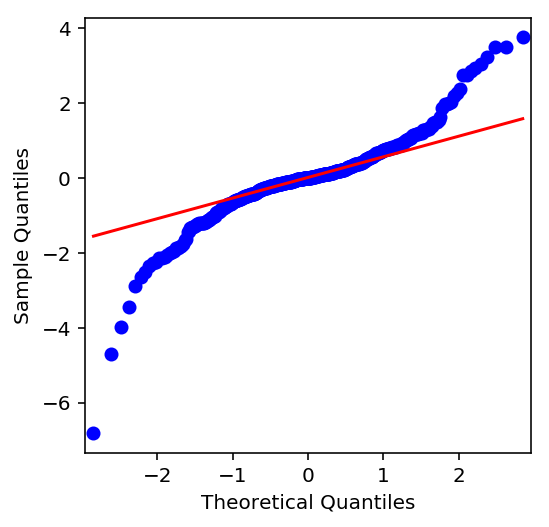

In [46]:
fig = plt.figure(figsize=(4,4))  # 波动率的正态分布检验
ax = fig.add_subplot(111)
fig = qqplot(btc_year_test['log_return_100x'], line='q', ax=ax, fit=True)

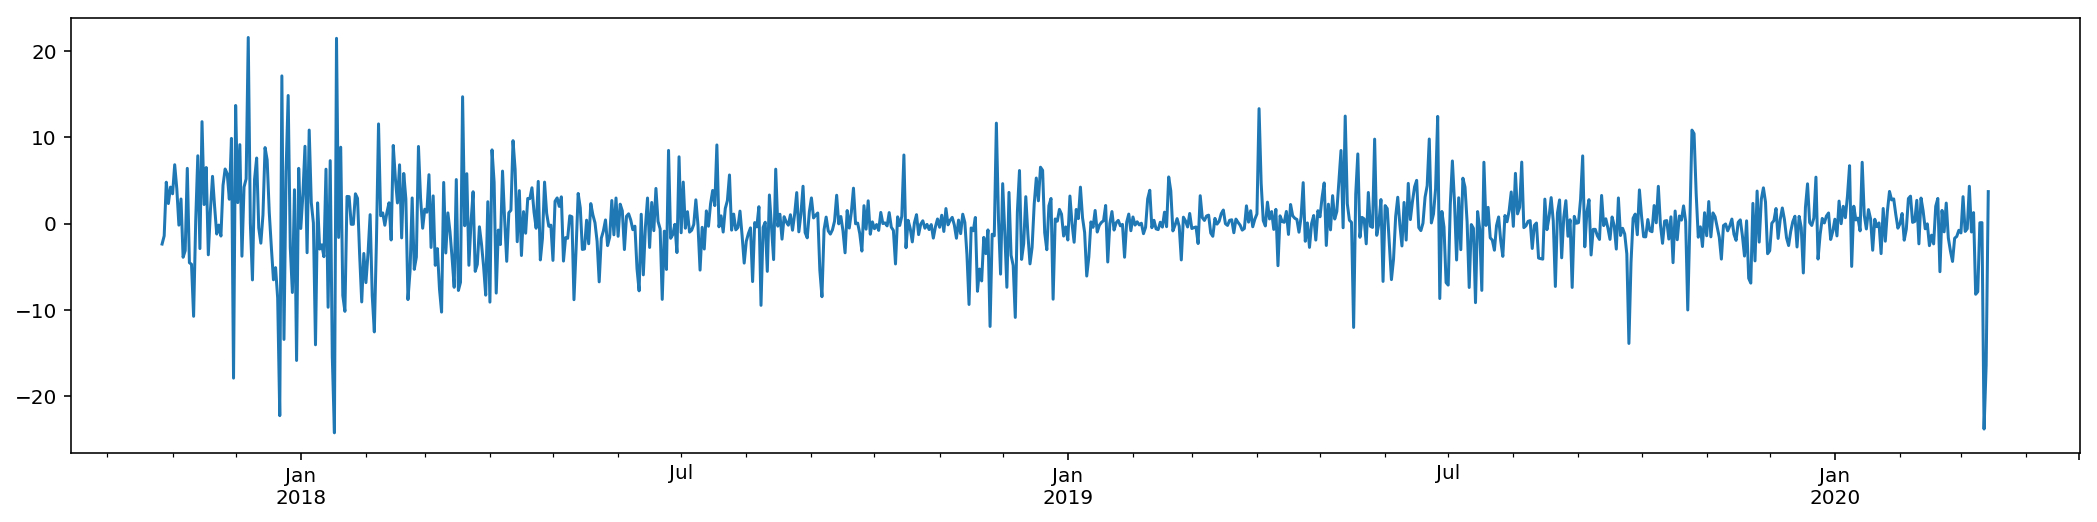

In [142]:
df = get_bars('huobi.btc_usdt', '1d', count=50000, start='2006-01-01')
btc_year = pd.DataFrame(df['close'],dtype=np.float)
btc_year.index.name = 'date'
btc_year.index = pd.to_datetime(btc_year.index)
btc_year['log_price'] = np.log(btc_year['close'])
btc_year['log_return'] = btc_year['log_price'] - btc_year['log_price'].shift(1)
btc_year['log_return_100x'] = np.multiply(btc_year['log_return'], 100)

btc_year_test = pd.DataFrame(btc_year['log_return_100x'].dropna(), dtype=np.float)
btc_year_test.index.name = 'date'
sns.mpl.rcParams['figure.figsize'] = (18, 4)  # 波动率
ax1 = btc_year_test['log_return_100x'].plot()
ax1.xaxis.label.set_visible(False)

## 第零点五步：数据准备

In [47]:
# 准备训练样本集
# df = pd.DataFrame(get_bars('huobi.btc_usdt', '1h', count=5753, start='2019-06-01'))
df = get_bars('huobi.btc_usdt', '1h', count=3000, start='2019-11-01') # 5753
kline_all = pd.DataFrame(df['close'],dtype=np.float)
kline_all.index.name = 'date' #gs.tz_localize('US/Eastern').tz_convert('UTC').head() 时区转换
kline_all.index = pd.to_datetime(kline_all.index)  # 将字符串索引转换成时间索引
# kline_all['return'] = kline_all['close'].pct_change().dropna()  # 计算收益率
# kline_all['return_100x'] = np.multiply(kline_all['return'], 100)
kline_all['log_price'] = np.log(kline_all['close'])  # 计算每日对数收益率
kline_all['log_return'] = kline_all['log_price'] - kline_all['log_price'].shift(1)  # 计算对数收益率 =diff
kline_all['log_return_100x'] = np.multiply(kline_all['log_return'], 100)  # 放大100倍
kline_all['squared_log_return'] = np.power(kline_all['log_return_100x'], 2)  # 对数日收益率的指数平方
kline_all['realized_variance_1_hour'] = kline_all.loc[:, 'squared_log_return'].resample('h', closed='left', label='left').sum() # 重采样至天
kline_all['realized_volatility_1_hour'] = np.sqrt(kline_all['realized_variance_1_hour'])
# kline_all['return_dif_1'] = kline_all['log_return_100x'].diff(1)  # 差分处理
kline_all['log_price_dif1'] = kline_all['log_price'].diff(1)
kline_all = kline_all[1:] # 由于最后一行缺失，因此去除最后一行
kline_train = kline_all[:2500]
# kline_all#.tail(3)
kline_train.head()

,close,log_price,log_return,log_return_100x,squared_log_return,realized_variance_1_hour,realized_volatility_1_hour,log_price_dif1
date,,,,,,,,
2019-11-01 01:00:00+08:00,9243.58,9.131685,0.000224,0.022396,0.000502,0.000502,0.022396,0.000224
2019-11-01 02:00:00+08:00,9232.10,9.130442,-0.001243,-0.124271,0.015443,0.015443,0.124271,-0.001243
2019-11-01 03:00:00+08:00,9210.92,9.128145,-0.002297,-0.229680,0.052753,0.052753,0.229680,-0.002297
2019-11-01 04:00:00+08:00,9181.23,9.124916,-0.003229,-0.322855,0.104236,0.104236,0.322855,-0.003229
2019-11-01 05:00:00+08:00,9126.27,9.118912,-0.006004,-0.600411,0.360494,0.360494,0.600411,-0.006004


In [48]:
# 准备样本外数据，带已实现日波动率
df = get_bars('huobi.btc_usdt', '1m', count=50000, start='2020-02-13')  # 取分钟数据
kline_1m = pd.DataFrame(df['close'], dtype=np.float)
kline_1m.index.name = 'date'
kline_1m['log_price'] = np.log(kline_1m['close'])
kline_1m['log_return'] = kline_1m['log_price'] - kline_1m['log_price'].shift(1)
kline_1m['log_return_100x'] = np.multiply(kline_1m['log_return'], 100)  # 放大100倍
kline_1m['squared_log_return'] = np.power(kline_1m['log_return_100x'], 2)
kline_1m#.tail()
df = get_bars('huobi.btc_usdt', '1h', count=860, start='2020-02-13')  # 取小时数据
kline_test = pd.DataFrame(df['close'], dtype=np.float)
kline_test.index.name = 'date'
kline_test['log_price'] = np.log(kline_test['close'])  # 计算每日对数收益率
kline_test['log_return'] = kline_test['log_price'] - kline_test['log_price'].shift(1)  # 计算对数收益率
kline_test['log_return_100x'] = np.multiply(kline_test['log_return'], 100)  # 放大100倍
kline_test['squared_log_return'] = np.power(kline_test['log_return_100x'], 2)  # 对数日收益率的指数平方
kline_test['realized_variance_1_hour'] = kline_1m.loc[:, 'squared_log_return'].resample('h', closed='left', label='left').sum() # 重采样至天
kline_test['realized_volatility_1_hour'] = np.sqrt(kline_test['realized_variance_1_hour'])  # 方差开方得波动率
kline_test = kline_test[4:-2] # 由于最后一行缺失，因此去除最后一行

training_label = 'log_price'
training_ts = pd.DataFrame(kline_train[training_label], dtype=np.float)
testing_ts = pd.DataFrame(kline_test[training_label], dtype=np.float)
# training_ts.head()
kline_test.head()

,close,log_price,log_return,log_return_100x,squared_log_return,realized_variance_1_hour,realized_volatility_1_hour
date,,,,,,,
2020-02-13 04:00:00+08:00,10375.4,9.247193,0.006052,0.605178,0.366240,0.193986,0.440438
2020-02-13 05:00:00+08:00,10375.8,9.247231,0.000039,0.003855,0.000015,0.199799,0.446989
2020-02-13 06:00:00+08:00,10339.3,9.243707,-0.003524,-0.352400,0.124186,0.063314,0.251623
2020-02-13 07:00:00+08:00,10329.8,9.242788,-0.000919,-0.091925,0.008450,0.263950,0.513761
2020-02-13 08:00:00+08:00,10368.8,9.246557,0.003768,0.376838,0.142007,0.177161,0.420905


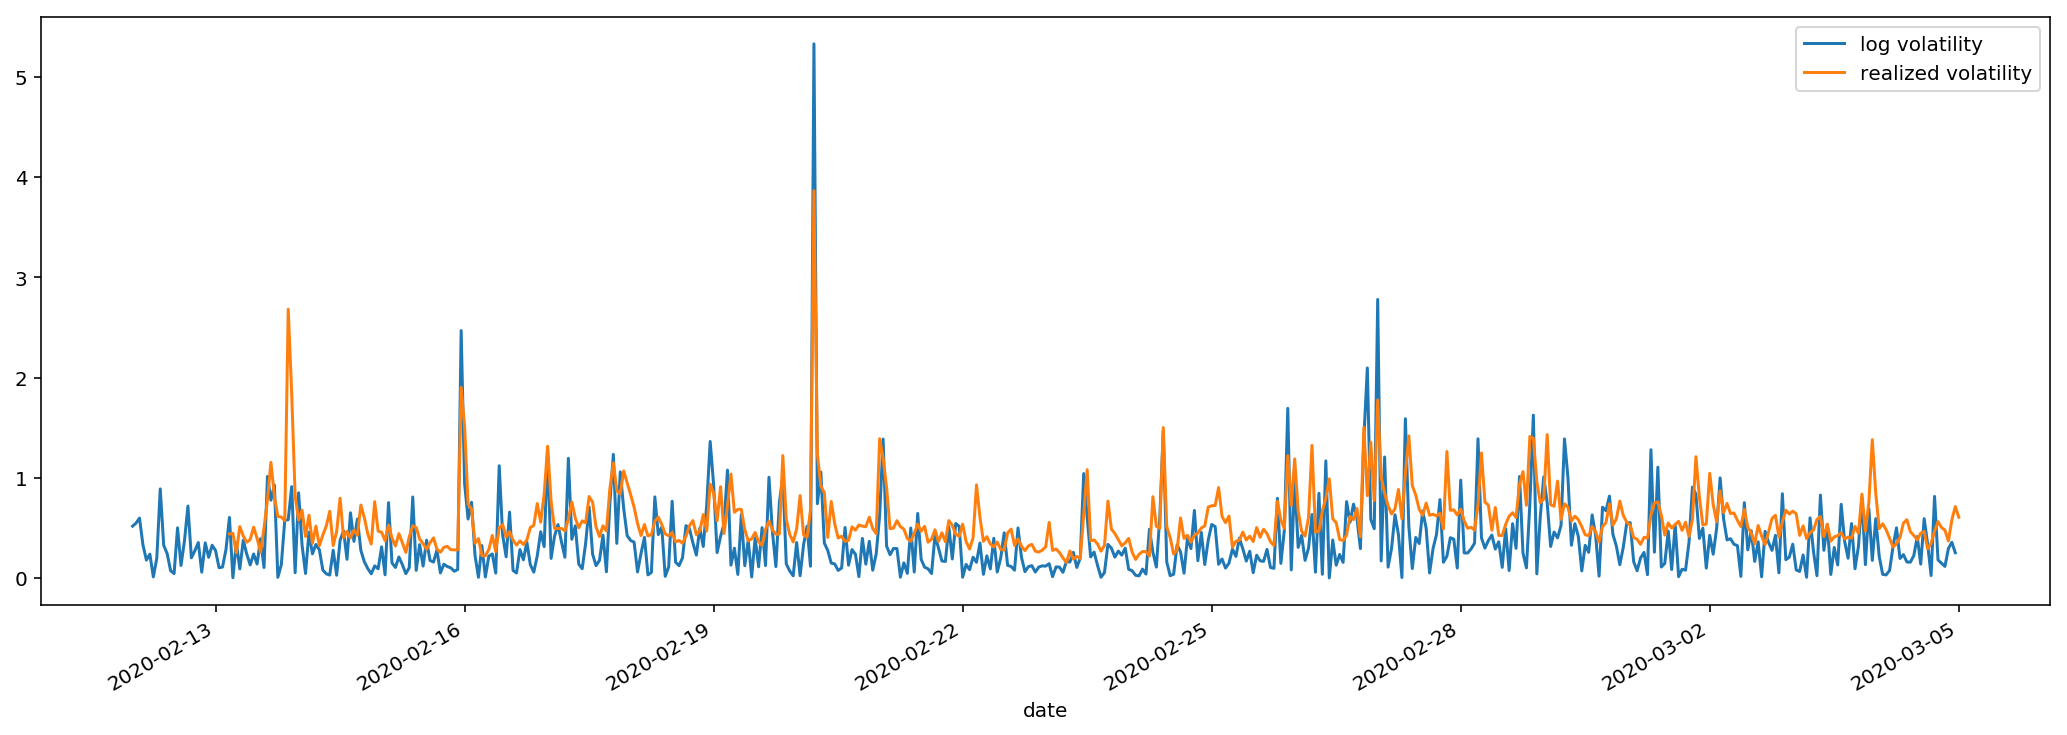

In [167]:
# sns.mpl.rcParams['figure.figsize'] = (18.0, 4.0)  # 波动率
# ax1 = kline_train.loc[:, ['log_return_100x']].plot()
# ax1 = kline_train.loc[:, ['log_return_100x', 'realized_volatility_1_hour']].plot()
# ax1.xaxis.label.set_visible(False)

fig, ax = plt.subplots(figsize=(18, 6))
start = '2020-02-12 00:00:00+08:00'
end = '2020-03-05 00:00:00+08:00'

np.abs(kline_all['log_return_100x']).loc[start:end].plot(ax=ax,label='log volatility')
kline_test['realized_volatility_1_hour'].loc[start:end].plot(ax=ax,label='realized volatility')
plt.legend(loc='best')

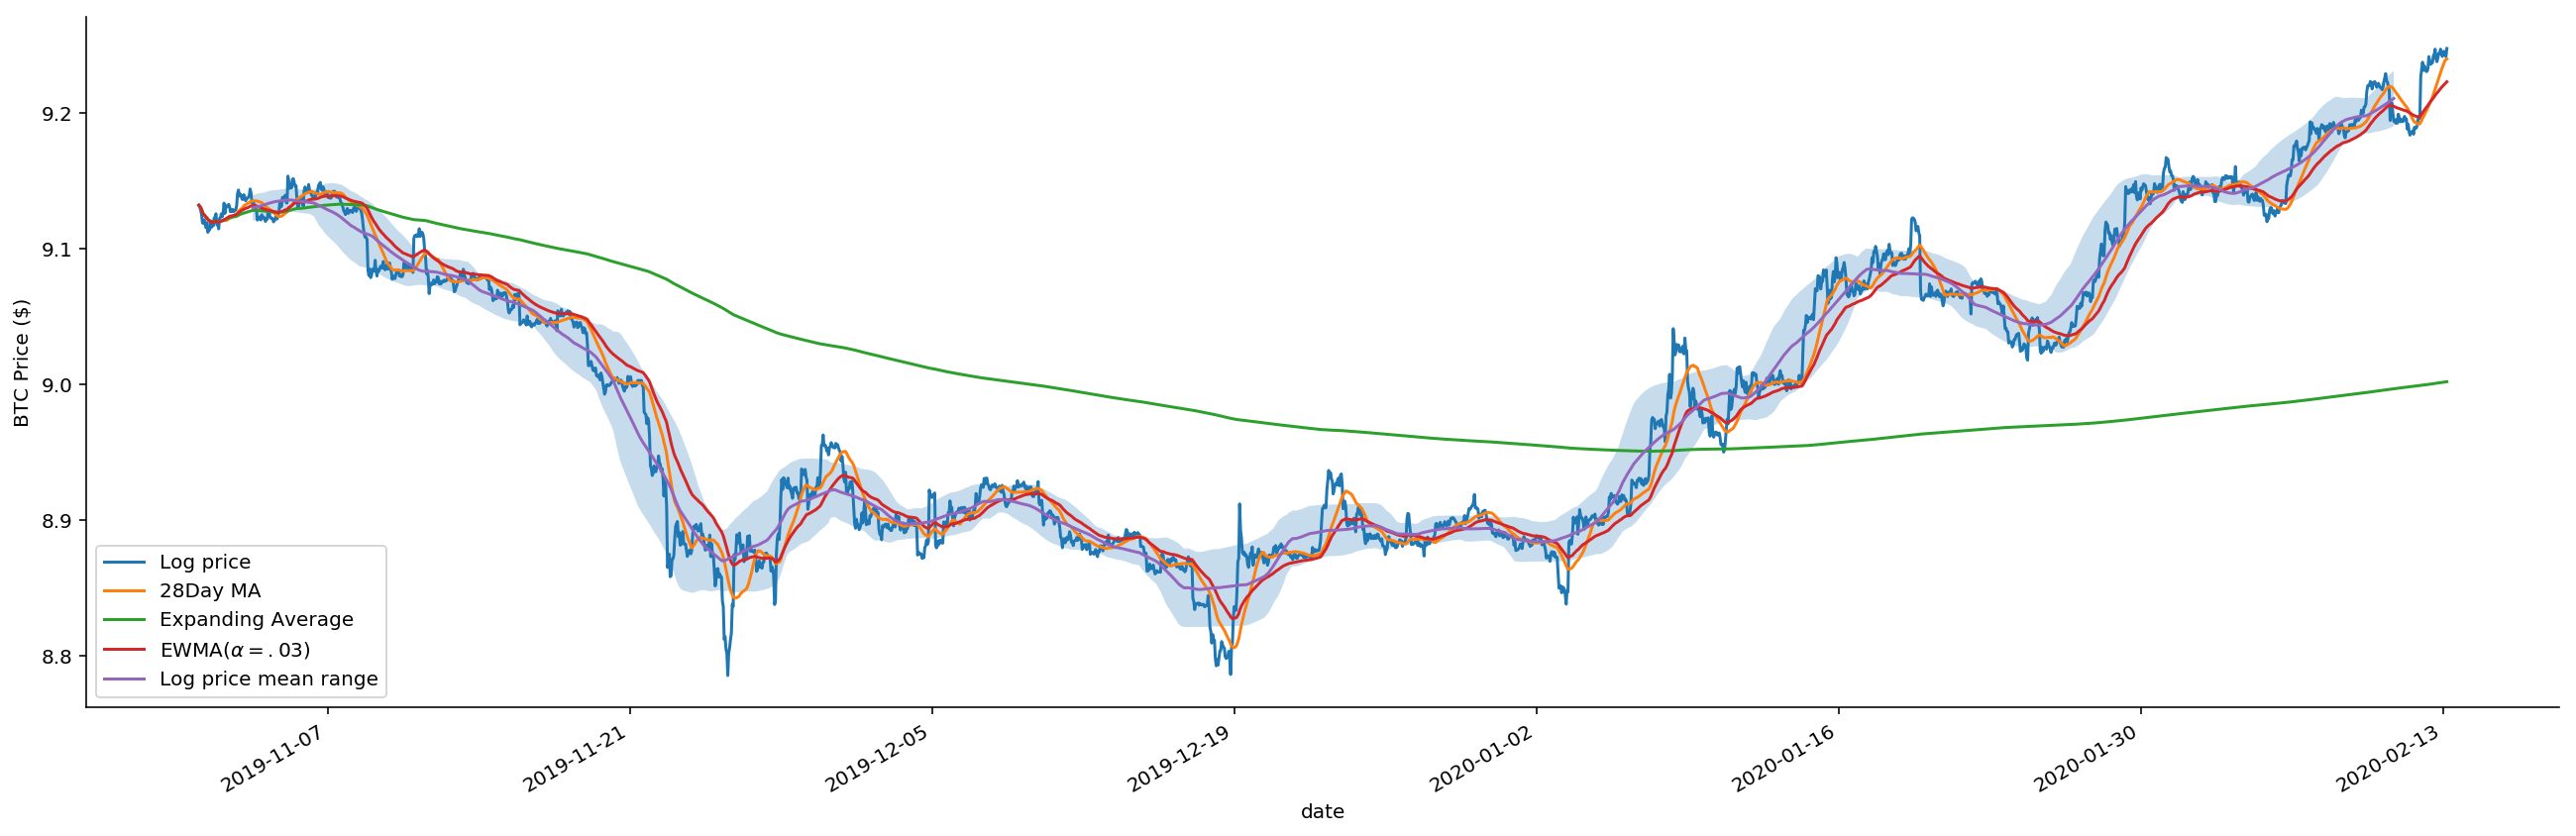

In [166]:
# 价格均线
kline_train['log_price'].plot(label='Log price',figsize=(18,6))
kline_train['log_price'].rolling(28).mean().plot(label='28Day MA')
# kline_train['log_return'].rolling(365).std().plot(label='28Day STD')
kline_train['log_price'].expanding().mean().plot(label='Expanding Average')
kline_train['log_price'].ewm(alpha=0.03).mean().plot(label='EWMA($\\alpha=.03$)')

roll = kline_train['log_price'].rolling(120, center=True)
# Rolling [window=30,center=True,axis=0]
m = roll.agg(['mean', 'std'])
ax = m['mean'].plot(label='Log price mean range')
ax.fill_between(m.index, m['mean'] - m['std'], m['mean'] + m['std'], alpha=.25)

plt.legend(loc='best')
plt.tight_layout()
plt.ylabel("BTC Price ($)")
sns.despine()

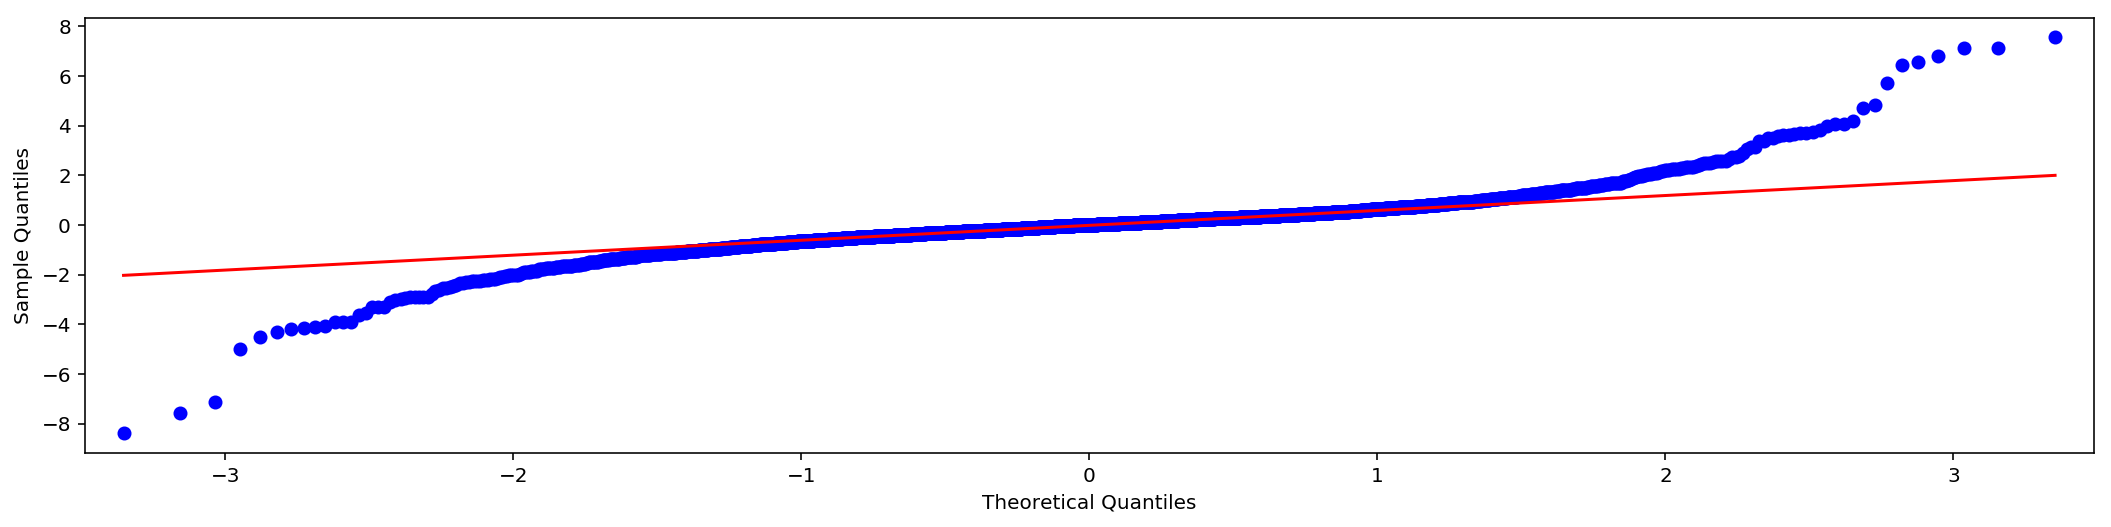

In [49]:
fig = plt.figure(figsize=(18,4))  # 波动率的正态分布检验
ax = fig.add_subplot(111)
fig = qqplot(kline_train['log_return_100x'], line='q', ax=ax, fit=True)

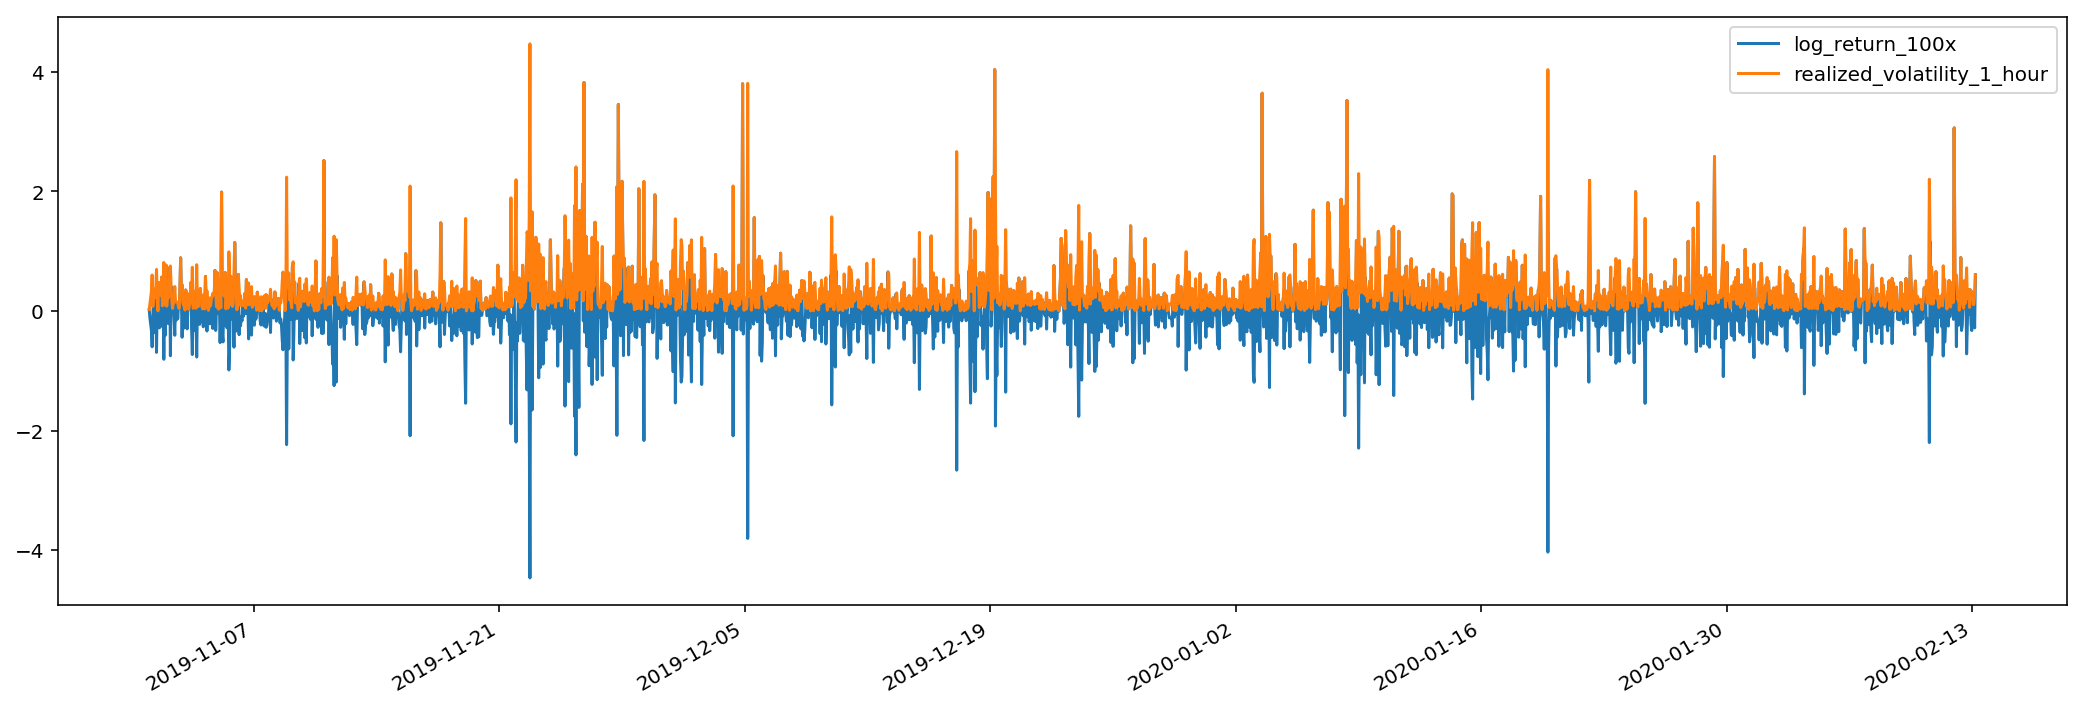

In [23]:
sns.mpl.rcParams['figure.figsize'] = (18, 6)  # 波动率
ax1 = kline_train.loc[:, ['log_return_100x', 'realized_volatility_1_hour']].plot()
ax1.xaxis.label.set_visible(False)

In [50]:
# 序列的正态分布检验
line_test = pd.DataFrame(kline_train['log_return_100x'].dropna(), dtype=np.float)
line_test.index.name = 'date'
mean = line_test.mean()  # 计算均值，标准差
std = line_test.std()
# .kstest方法：KS检验，参数分别是：待检验的数据，检验方法（这里设置成norm正态分布），均值与标准差
# 结果返回两个值：statistic → D值，pvalue → P值
# p值大于0.05，为正态分布
normal_result = pd.DataFrame(index=['Mean Value', 'Std Value', 'Skewness Value','Kurtosis Value',
                                    'Ks Test Value','Ks Test P-value',
                                    'Jarque Bera Test','Jarque Bera Test P-value'],
                    columns=['model value'])
normal_result['model value']['Mean Value'] = ('%.4f'% mean[0])
normal_result['model value']['Std Value'] = ('%.4f'% std[0])
normal_result['model value']['Skewness Value'] = ('%.4f'% line_test.skew())
normal_result['model value']['Kurtosis Value'] = ('%.4f'% line_test.kurt())
normal_result['model value']['Ks Test Value'] = stats.kstest(line_test, 'norm', (mean, std))[0]
normal_result['model value']['Ks Test P-value'] = stats.kstest(line_test, 'norm', (mean, std))[1]
normal_result['model value']['Jarque Bera Test'] = stats.jarque_bera(line_test)[0]
normal_result['model value']['Jarque Bera Test P-value'] = stats.jarque_bera(line_test)[1]
normal_result

,model value
Mean Value,0.0046
Std Value,0.5338
Skewness Value,0.3418
Kurtosis Value,12.5113
Ks Test Value,1
Ks Test P-value,0
Jarque Bera Test,16282.7
Jarque Bera Test P-value,0


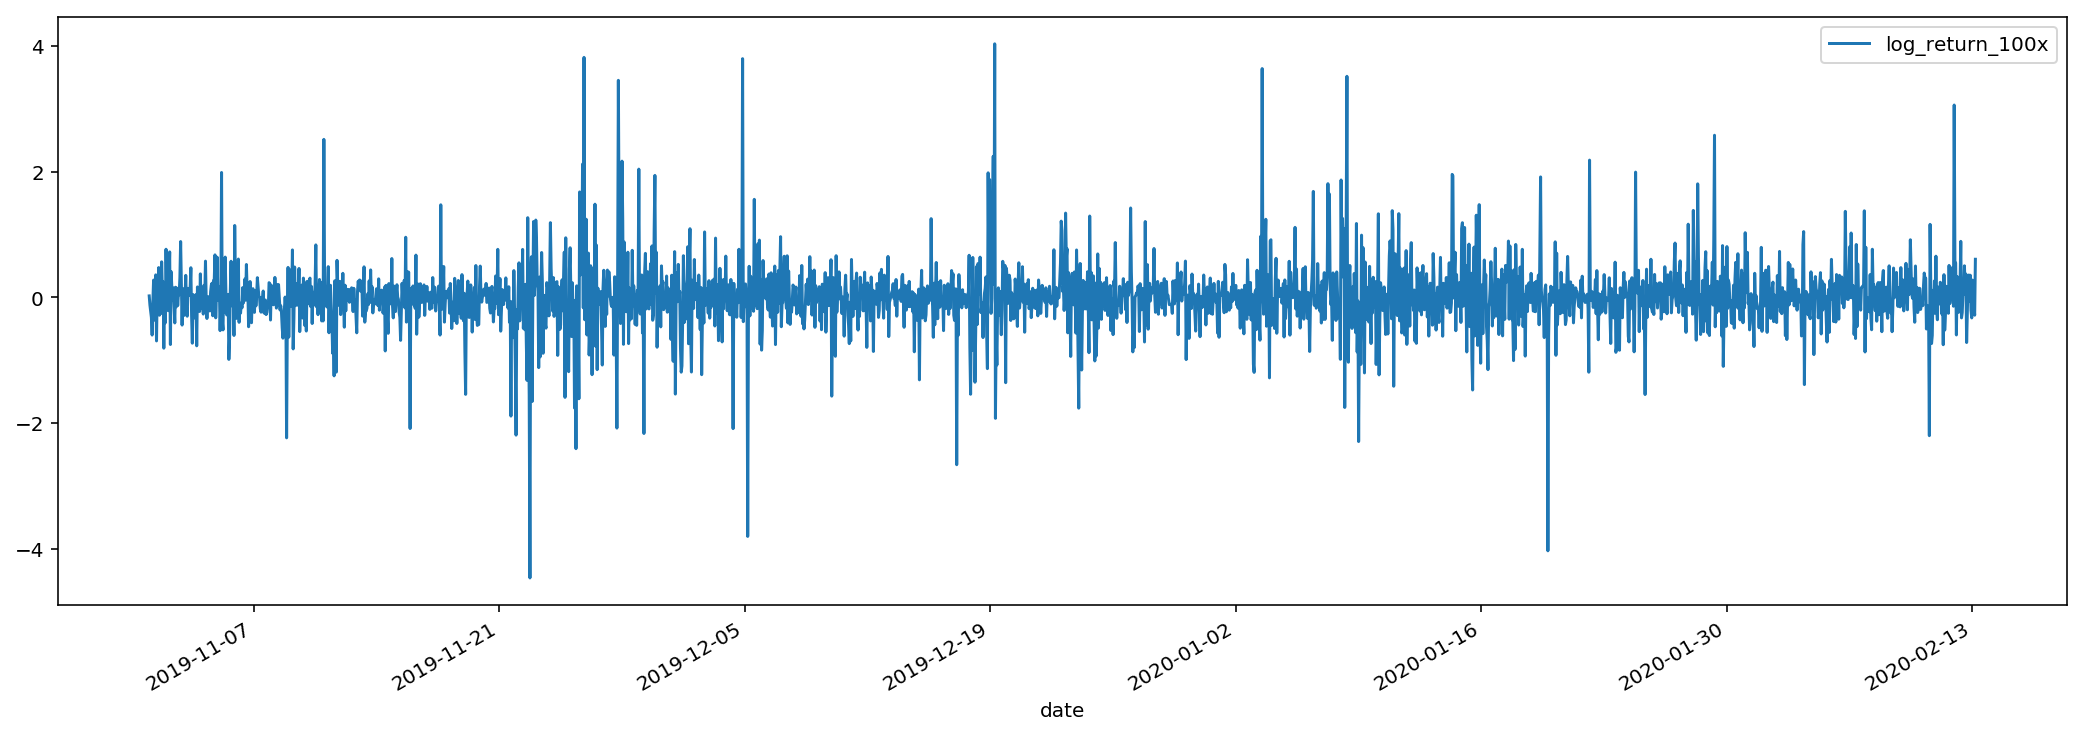

In [57]:
sns.mpl.rcParams['figure.figsize'] = (18, 6)  # 波动率
ax1 = line_test.plot()
ax1.xaxis.label.set_visible(True)

NameError: name 's_r' is not defined

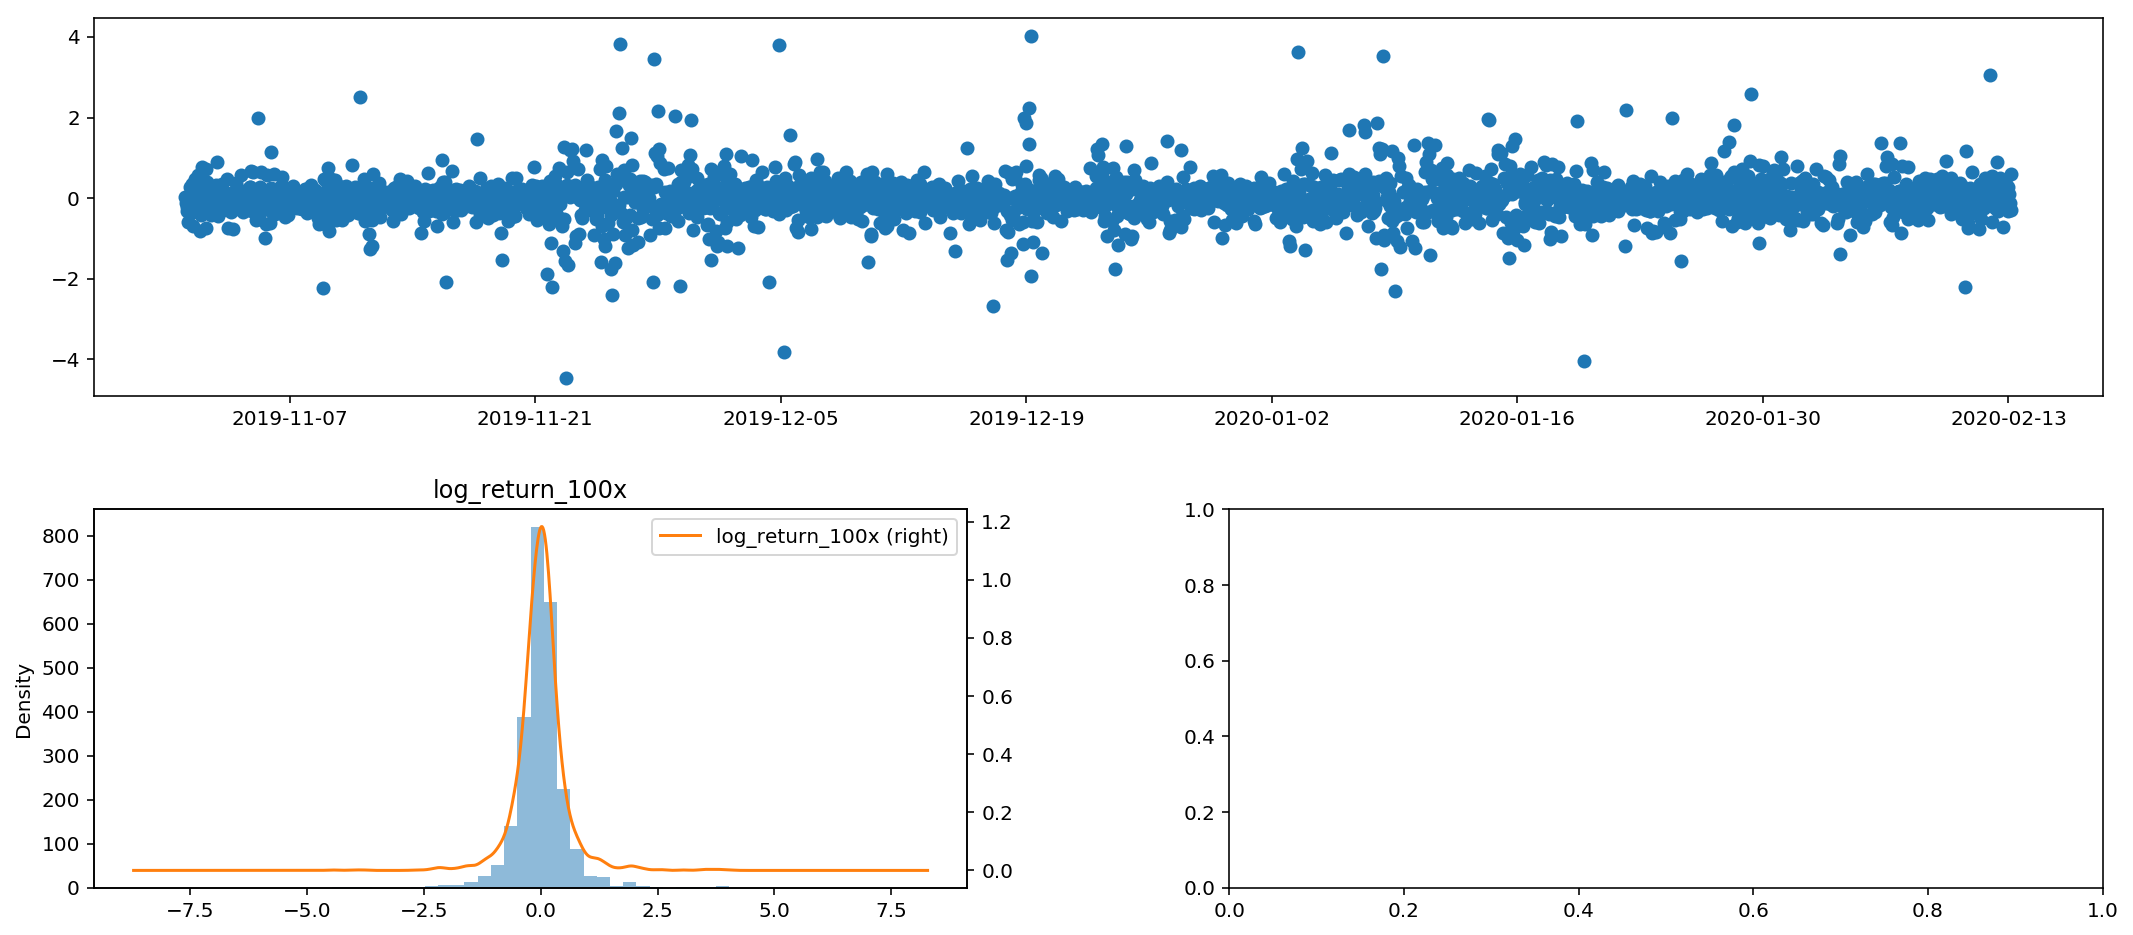

In [58]:
fig = plt.figure(figsize = (18,8))
layout = (2, 2)
ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)# 绘制数据分布图
ax2 = plt.subplot2grid(layout, (1, 0))# 绘制直方图
ax3 = plt.subplot2grid(layout, (1, 1))# 绘制QQ图，直线为四分之一位数、四分之三位数的连线，基本符合正态分布

ax1.scatter(line_test.index, line_test.values)
line_test.hist(bins=30,alpha = 0.5,ax = ax2)
line_test.plot(kind = 'kde', secondary_y=True,ax = ax2)
ax3.plot(s_r['p'],s_r['log_return_100x'],'k.',alpha = 0.1)
ax3.plot([x1,x2],[y1,y2],'-r')
sns.despine()
plt.tight_layout()


## 第一步：检验平稳性

In [200]:
#平稳性ADF检验 原假设是非平稳
#we can just take the natural log of the price and be done with it
# https://0xboz.github.io/blog/how-to-create-arima-model-forecasting-btc-usd-in-python-part-1/
stable_test = kline_all['log_price_dif1']#kline_train['log_price']
adftest = sm.tsa.stattools.adfuller(np.array(stable_test), autolag='AIC')
adftest2 = sm.tsa.stattools.adfuller(np.array(stable_test), autolag='BIC')
output=pd.DataFrame(index=['ADF Statistic Test Value', "ADF P-value", "Lags", "Number of Observations",
                           "Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],
                    columns=['AIC','BIC'])
output['AIC']['ADF Statistic Test Value'] = adftest[0]
output['AIC']['ADF P-value'] = adftest[1]
output['AIC']['Lags'] = adftest[2]
output['AIC']['Number of Observations'] = adftest[3]
output['AIC']['Critical Value(1%)'] = adftest[4]['1%']
output['AIC']['Critical Value(5%)'] = adftest[4]['5%']
output['AIC']['Critical Value(10%)'] = adftest[4]['10%']
output['BIC']['ADF Statistic Test Value'] = adftest2[0]
output['BIC']['ADF P-value'] = adftest2[1]
output['BIC']['Lags'] = adftest2[2]
output['BIC']['Number of Observations'] = adftest2[3]
output['BIC']['Critical Value(1%)'] = adftest2[4]['1%']
output['BIC']['Critical Value(5%)'] = adftest2[4]['5%']
output['BIC']['Critical Value(10%)'] = adftest2[4]['10%']
output# 返回统计量、p-value 等
# H0：存在单位根，即非平稳
# p-value>0.05，接受原假设，序列有一个单位根，即证明序列非平稳
# p-value<0.05，因此拒绝原假设，认为时间序列平稳，可以使用统计时序模型进行建模
# 若时间序列非平稳，进行差分，使其变的平稳，得到dif1和dif2

,AIC,BIC
ADF Statistic Test Value,-10.9438,-56.1186
ADF P-value,9.15394e-20,0
Lags,26,0
Number of Observations,2972,2998
Critical Value(1%),-3.43255,-3.43253
Critical Value(5%),-2.86251,-2.8625
Critical Value(10%),-2.56729,-2.56728


## 第二步：模型识别

(<matplotlib.axes._subplots.AxesSubplot at 0x1c19d27e10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c36683320>)

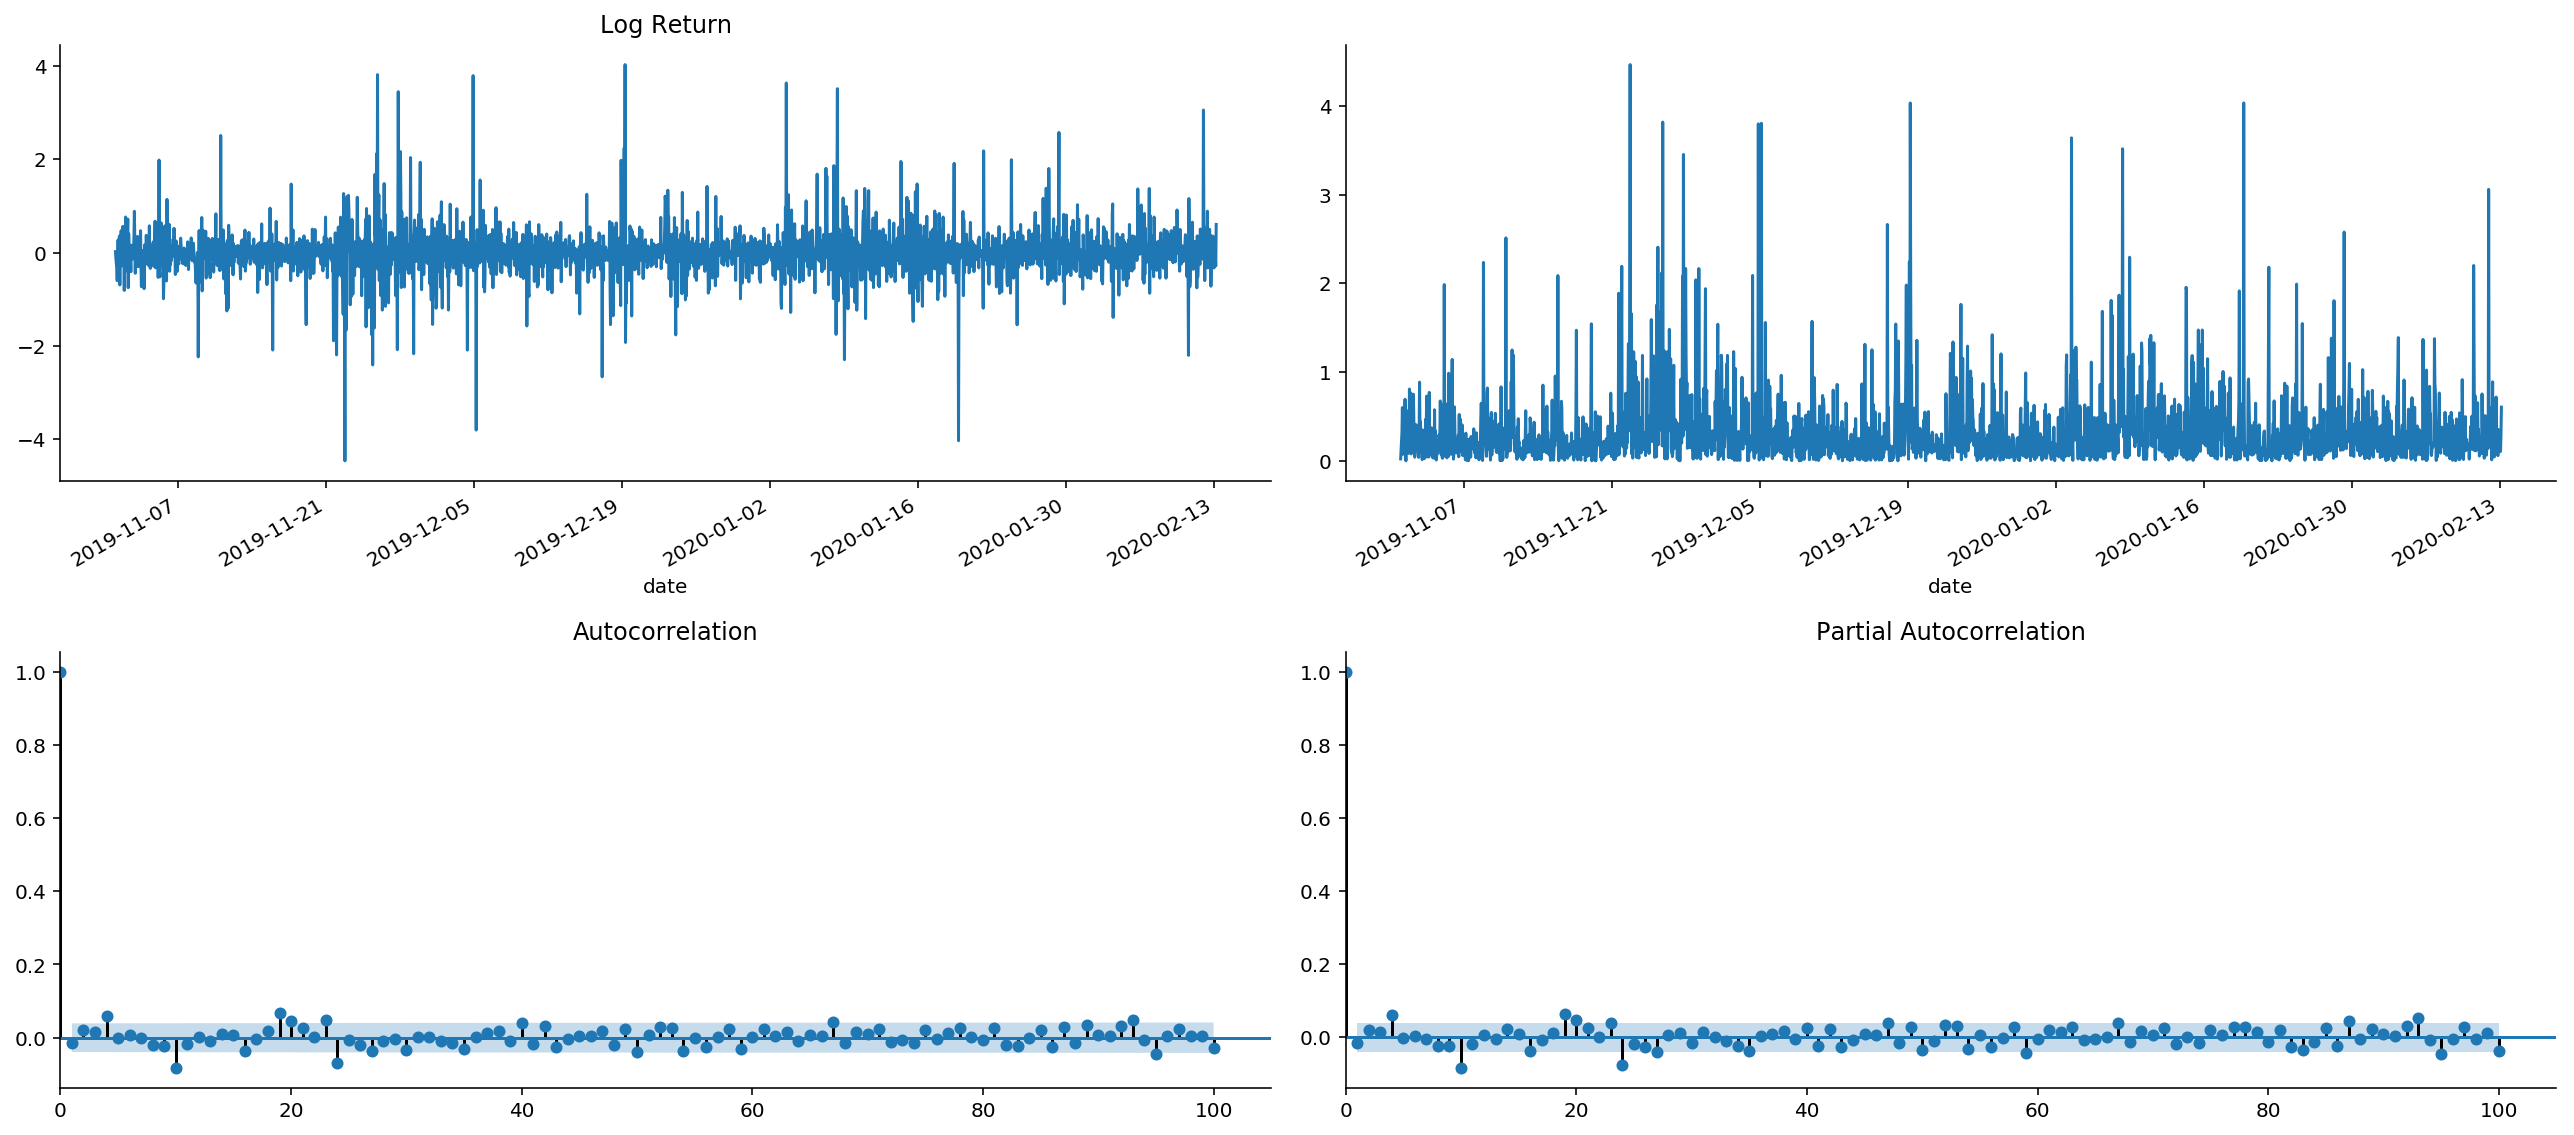

In [86]:
# 绘制图形，自相关和偏相关图
# ACF和PACF图 https://www.biaodianfu.com/acf-pacf.html
tsplot(kline_train['log_return_100x'], kline_train['realized_volatility_1_hour'], title='Log Return', lags=100)

In [142]:
#自相关函数（ACF）的白噪声检验
acf,q,p = sm.tsa.acf(training_ts[training_label], nlags=15,unbiased=True,qstat = True, fft=False)  # 检验10个自相关系数
output = pd.DataFrame(np.c_[range(1,16), acf[1:], q, p], columns=['lag', 'ACF', 'Q', 'P-value'])
output = output.set_index('lag')
output

,ACF,Q,P-value
lag,,,
1.0,0.998041,2493.203538,0.0
2.0,0.996166,4978.044438,0.0
3.0,0.994231,7454.231231,0.0
4.0,0.992267,9921.630484,0.0
5.0,0.990196,12379.729033,0.0
6.0,0.988153,14828.674774,0.0
7.0,0.986057,17268.221647,0.0
8.0,0.983957,19698.360908,0.0
9.0,0.981942,22119.531668,0.0


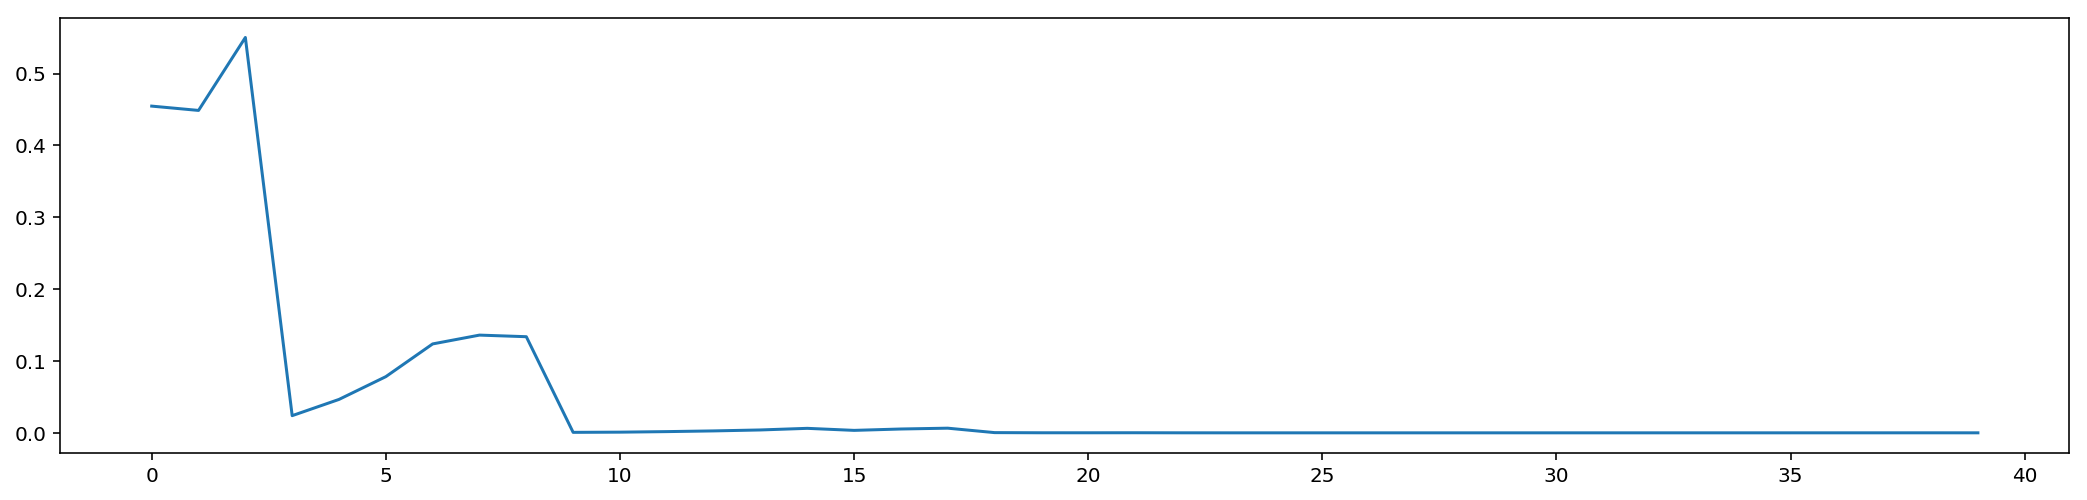

In [194]:
# LB的白噪声检验 https://www.cnblogs.com/travelcat/p/11400307.html)
lb_test(training_ts[training_label],lags=None,boxpierce=False)
plt.subplots(figsize=(18, 4))
plt.plot((lb_test(kline_train['log_return_100x'],lags=None,boxpierce=False))[1])
plt.show()

## 第三步： ARIMA定阶

AIC best param: (0, 1, 0)
BIC best param: (0, 1, 0)
HQIC best param: (0, 1, 0)
Best Param Selected: (0, 1, 0)


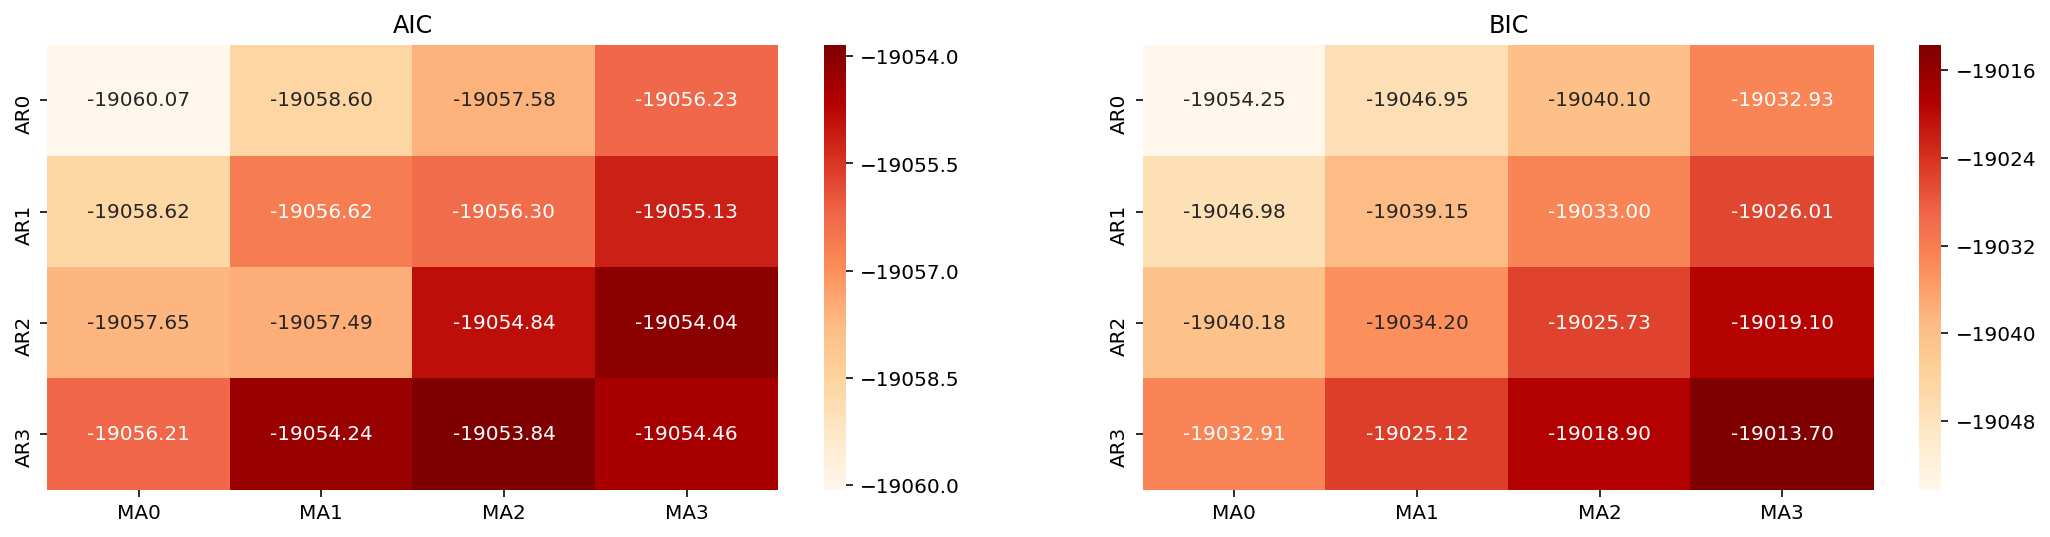

In [117]:
def select_best_params():
    # Initial approximation of parameters
    ps = range(0, 4)
    ds= range(1, 2)
    qs = range(0, 4)
    parameters = product(ps, ds, qs)
    parameters_list = list(parameters)

    p_min = 0
    d_min = 0
    q_min = 0
    p_max = 3
    d_max = 3
    q_max = 3

    # Initialize a DataFrame to store the results
    results_aic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                               columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
    results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                               columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
    
    # Model Selection
    best_params = []
    aic_results = []
    bic_results = []
    hqic_results = []
    best_aic = float("inf")
    best_bic = float("inf")
    best_hqic = float("inf")
    warnings.filterwarnings('ignore')
    for param in parameters_list:
        try:
            model = sm.tsa.SARIMAX(training_ts[training_label], order=(param[0], param[1], param[2])).fit(disp=-1)
            results_aic.loc['AR{}'.format(param[0]), 'MA{}'.format(param[2])] = model.aic
            results_bic.loc['AR{}'.format(param[0]), 'MA{}'.format(param[2])] = model.bic
        except ValueError:
            continue    
           
        aic_results.append([param, model.aic])
        bic_results.append([param, model.bic])
        hqic_results.append([param, model.hqic])
    
    results_aic = results_aic[results_aic.columns].astype(float)
    results_bic = results_bic[results_bic.columns].astype(float)
    
    # 绘制AIC和BIC的热力图，寻找最优
    fig = plt.figure(figsize=(18, 9))
    layout = (2, 2)
    aic_ax = plt.subplot2grid(layout, (0, 0))
    bic_ax = plt.subplot2grid(layout, (0, 1))

    aic_ax = sns.heatmap(results_aic,mask=results_aic.isnull(),ax=aic_ax,cmap='OrRd',annot=True,fmt='.2f',);
    aic_ax.set_title('AIC');
    bic_ax = sns.heatmap(results_bic,mask=results_bic.isnull(),ax=bic_ax,cmap='OrRd',annot=True,fmt='.2f',);
    bic_ax.set_title('BIC');
    
    aic_df = pd.DataFrame(aic_results)
    aic_df.columns = ['params', 'aic']   
    best_params.append(aic_df.params[aic_df.aic.idxmin()])
    print('AIC best param: {}'.format(aic_df.params[aic_df.aic.idxmin()]))
    
    bic_df = pd.DataFrame(bic_results)
    bic_df.columns = ['params', 'bic']
    best_params.append(bic_df.params[bic_df.bic.idxmin()])
    print('BIC best param: {}'.format(bic_df.params[bic_df.bic.idxmin()]))
    
    hqic_df = pd.DataFrame(hqic_results)
    hqic_df.columns = ['params', 'hqic']
    best_params.append(hqic_df.params[hqic_df.hqic.idxmin()])
    print('HQIC best param: {}'.format(hqic_df.params[hqic_df.hqic.idxmin()]))

    for best_param in best_params:
        if best_params.count(best_param)>=2:
            print('Best Param Selected: {}'.format(best_param))
            return best_param 

best_param = select_best_params()

In [119]:
# Alternative model selection method, limited to only searching AR and MA parameters
train_results = sm.tsa.arma_order_select_ic(kline_train['log_return_100x'], ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)
print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 4)
BIC (1, 0)


In [ ]:
import itertools
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(training_ts, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            print('ARIMA{}x{} - BIC:{}'.format(param, param_seasonal, results.bic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:18076.892304411507
ARIMA(0, 0, 0)x(0, 0, 0, 12) - BIC:18082.715950342343
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:14620.66362629555
ARIMA(0, 0, 0)x(0, 0, 1, 12) - BIC:14632.301291183157
ARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC:11277.16457476343
ARIMA(0, 0, 0)x(0, 0, 2, 12) - BIC:11294.606561788438
ARIMA(0, 0, 0)x(0, 0, 3, 12) - AIC:11262.680176715478
ARIMA(0, 0, 0)x(0, 0, 3, 12) - BIC:11285.916718307959
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:-12647.026987922562
ARIMA(0, 0, 0)x(0, 1, 0, 12) - BIC:-12641.208155478758
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:-12578.053560484237
ARIMA(0, 0, 0)x(0, 1, 1, 12) - BIC:-12566.425569134231
ARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC:-12507.283914350199
ARIMA(0, 0, 0)x(0, 1, 2, 12) - BIC:-12489.856508155837
ARIMA(0, 0, 0)x(0, 1, 3, 12) - AIC:-12435.81181029499
ARIMA(0, 0, 0)x(0, 1, 3, 12) - BIC:-12412.594804760878
ARIMA(0, 0, 0)x(0, 2, 0, 12) - AIC:-10759.158083772272
ARIMA(0, 0, 0)x(0, 2, 0, 12) - BIC:-10753.34408809727
ARIMA(0, 0, 0)x(0, 2, 

ARIMA(0, 0, 1)x(0, 3, 0, 12) - AIC:-10728.93738382927
ARIMA(0, 0, 1)x(0, 3, 0, 12) - BIC:-10717.319925215781
ARIMA(0, 0, 1)x(0, 3, 1, 12) - AIC:nan
ARIMA(0, 0, 1)x(0, 3, 1, 12) - BIC:nan
ARIMA(0, 0, 1)x(0, 3, 2, 12) - AIC:-13144.07329846068
ARIMA(0, 0, 1)x(0, 3, 2, 12) - BIC:-13120.877565220515
ARIMA(0, 0, 1)x(0, 3, 3, 12) - AIC:-13062.161639374448
ARIMA(0, 0, 1)x(0, 3, 3, 12) - BIC:-13033.191643926928
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:-14810.206957140743
ARIMA(0, 0, 1)x(1, 0, 0, 12) - BIC:-14792.749253779166
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:-14851.004106717728
ARIMA(0, 0, 1)x(1, 0, 1, 12) - BIC:-14827.730385629446
ARIMA(0, 0, 1)x(1, 0, 2, 12) - AIC:-14772.770075668763
ARIMA(0, 0, 1)x(1, 0, 2, 12) - BIC:-14743.702117904
ARIMA(0, 0, 1)x(1, 0, 3, 12) - AIC:-14695.30419216648
ARIMA(0, 0, 1)x(1, 0, 3, 12) - BIC:-14660.451816326015
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:-14776.692959066067
ARIMA(0, 0, 1)x(1, 1, 0, 12) - BIC:-14759.249760164654
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:-14770.066861

ARIMA(0, 0, 2)x(1, 2, 0, 12) - AIC:-14535.828797291379
ARIMA(0, 0, 2)x(1, 2, 0, 12) - BIC:-14512.590631992765
ARIMA(0, 0, 2)x(1, 2, 1, 12) - AIC:-15806.621537052171
ARIMA(0, 0, 2)x(1, 2, 1, 12) - BIC:-15777.579921800216
ARIMA(0, 0, 2)x(1, 2, 2, 12) - AIC:-15767.507010279294
ARIMA(0, 0, 2)x(1, 2, 2, 12) - BIC:-15732.686399937582
ARIMA(0, 0, 2)x(1, 2, 3, 12) - AIC:-15692.627086181024
ARIMA(0, 0, 2)x(1, 2, 3, 12) - BIC:-15652.037424805649
ARIMA(0, 0, 2)x(1, 3, 0, 12) - AIC:-13609.303370624584
ARIMA(0, 0, 2)x(1, 3, 0, 12) - BIC:-13586.08473343636
ARIMA(0, 0, 2)x(1, 3, 1, 12) - AIC:-14455.835496227974
ARIMA(0, 0, 2)x(1, 3, 1, 12) - BIC:-14426.818320943214
ARIMA(0, 0, 2)x(1, 3, 2, 12) - AIC:-14520.006521249194
ARIMA(0, 0, 2)x(1, 3, 2, 12) - BIC:-14485.215382927443
ARIMA(0, 0, 2)x(1, 3, 3, 12) - AIC:-14446.096022693213
ARIMA(0, 0, 2)x(1, 3, 3, 12) - BIC:-14405.540915069612
ARIMA(0, 0, 2)x(2, 0, 0, 12) - AIC:-15959.509858707454
ARIMA(0, 0, 2)x(2, 0, 0, 12) - BIC:-15930.437860538432
ARIMA(0, 0,

## 第四步： ARIMA建模和拟合

So the nonseasonal component is
$p=1$: period autoregressive: use $y_{t-1}$
$d=1$: one first-differencing of the data (one month)
$q=2$: use the previous two non-seasonal residual, $e_{t-1}$ and $e_{t-2}$, to forecast
And the seasonal component is
$P=0$: Don't use any previous seasonal values
$D=1$: Difference the series 12 periods back: y.diff(12)
$Q=2$: Use the two previous seasonal residuals
$s$ is the periodicity (4 for quarterly, 12 for monthly).

In [23]:
# ARIMA 建模
# 参数说明：https://www.biaodianfu.com/sarimax.html
params = (1, 2, 1)
training_model = smt.SARIMAX(endog=training_ts, trend='c', order=params, 
                             seasonal_order=(0, 0, 0, 0)#(1, 1, 2, 12)#, 
#                              simple_differencing=False,
#                              enforce_stationarity=False,
#                              enforce_invertibility=False
                            ) # 1\1\2\12
# training_model = smt.ARIMA(endog=training_ts, order=params)
model_results = training_model.fit(disp=False)
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:              log_price   No. Observations:                 2500
Model:               SARIMAX(1, 2, 1)   Log Likelihood                9388.051
Date:                Tue, 24 Mar 2020   AIC                         -18768.103
Time:                        10:50:49   BIC                         -18744.810
Sample:                    11-01-2019   HQIC                        -18759.646
                         - 02-13-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   7.293e-07   2.56e-05      0.029      0.977   -4.94e-05    5.08e-05
ar.L1         -0.0155      0.017     -0.900      0.368      -0.049       0.018
ma.L1         -0.7738      0.013    -59.434      0.000      -0.799      -0.748
sigma2      3.179e-05   3.84e-07     82.734      0.000     3.1e-05    3.25e-05
===================================================================================
Ljung-Box (Q):                      152.95   Jarque-Bera (JB):              8398.67
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

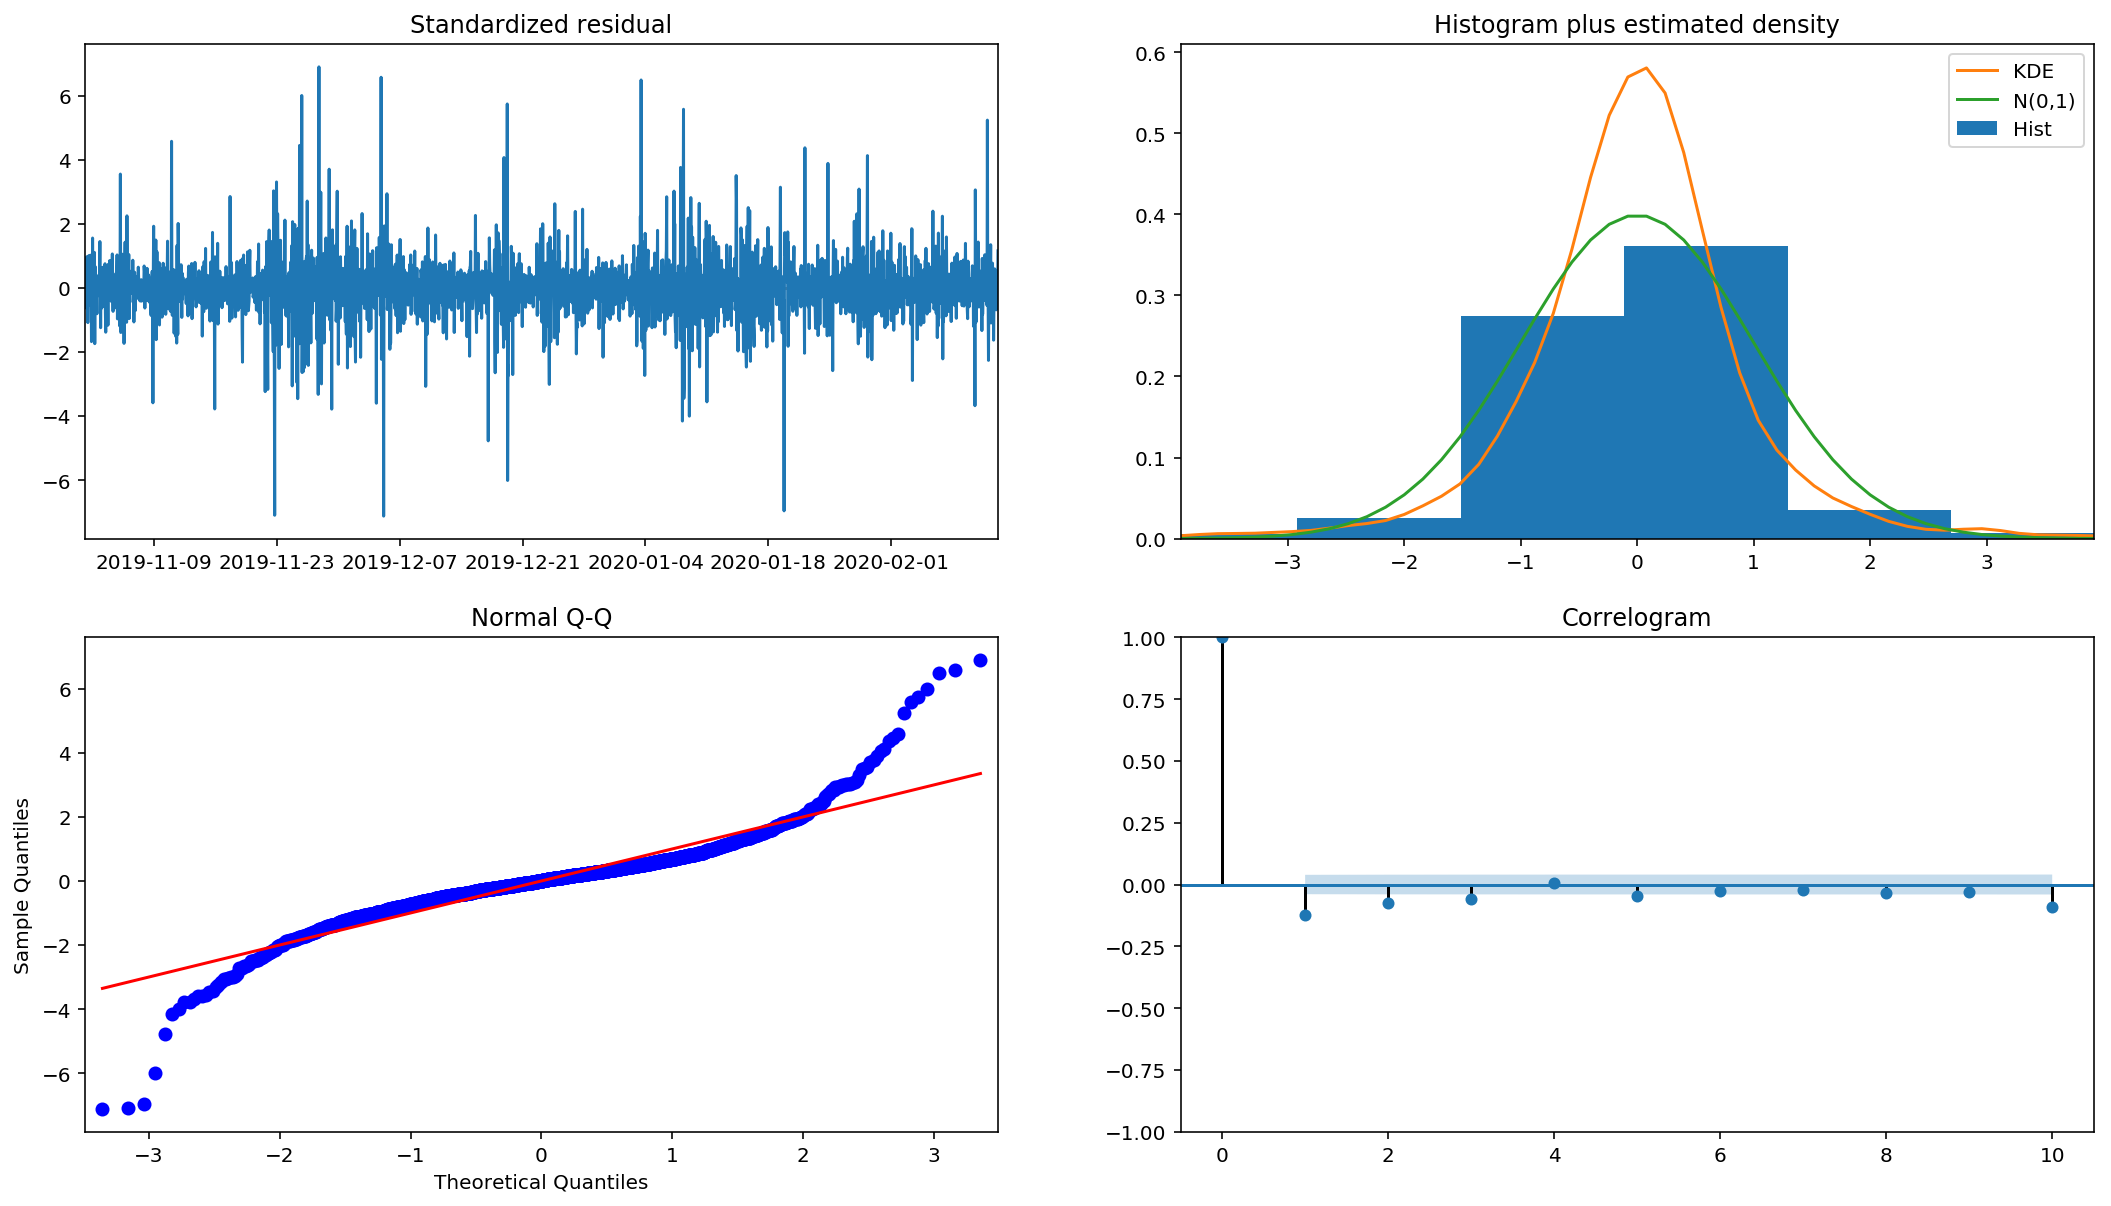

In [24]:
model_results.plot_diagnostics(figsize=(18, 10));

(<matplotlib.axes._subplots.AxesSubplot at 0x1c3905cc88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c3917aef0>)

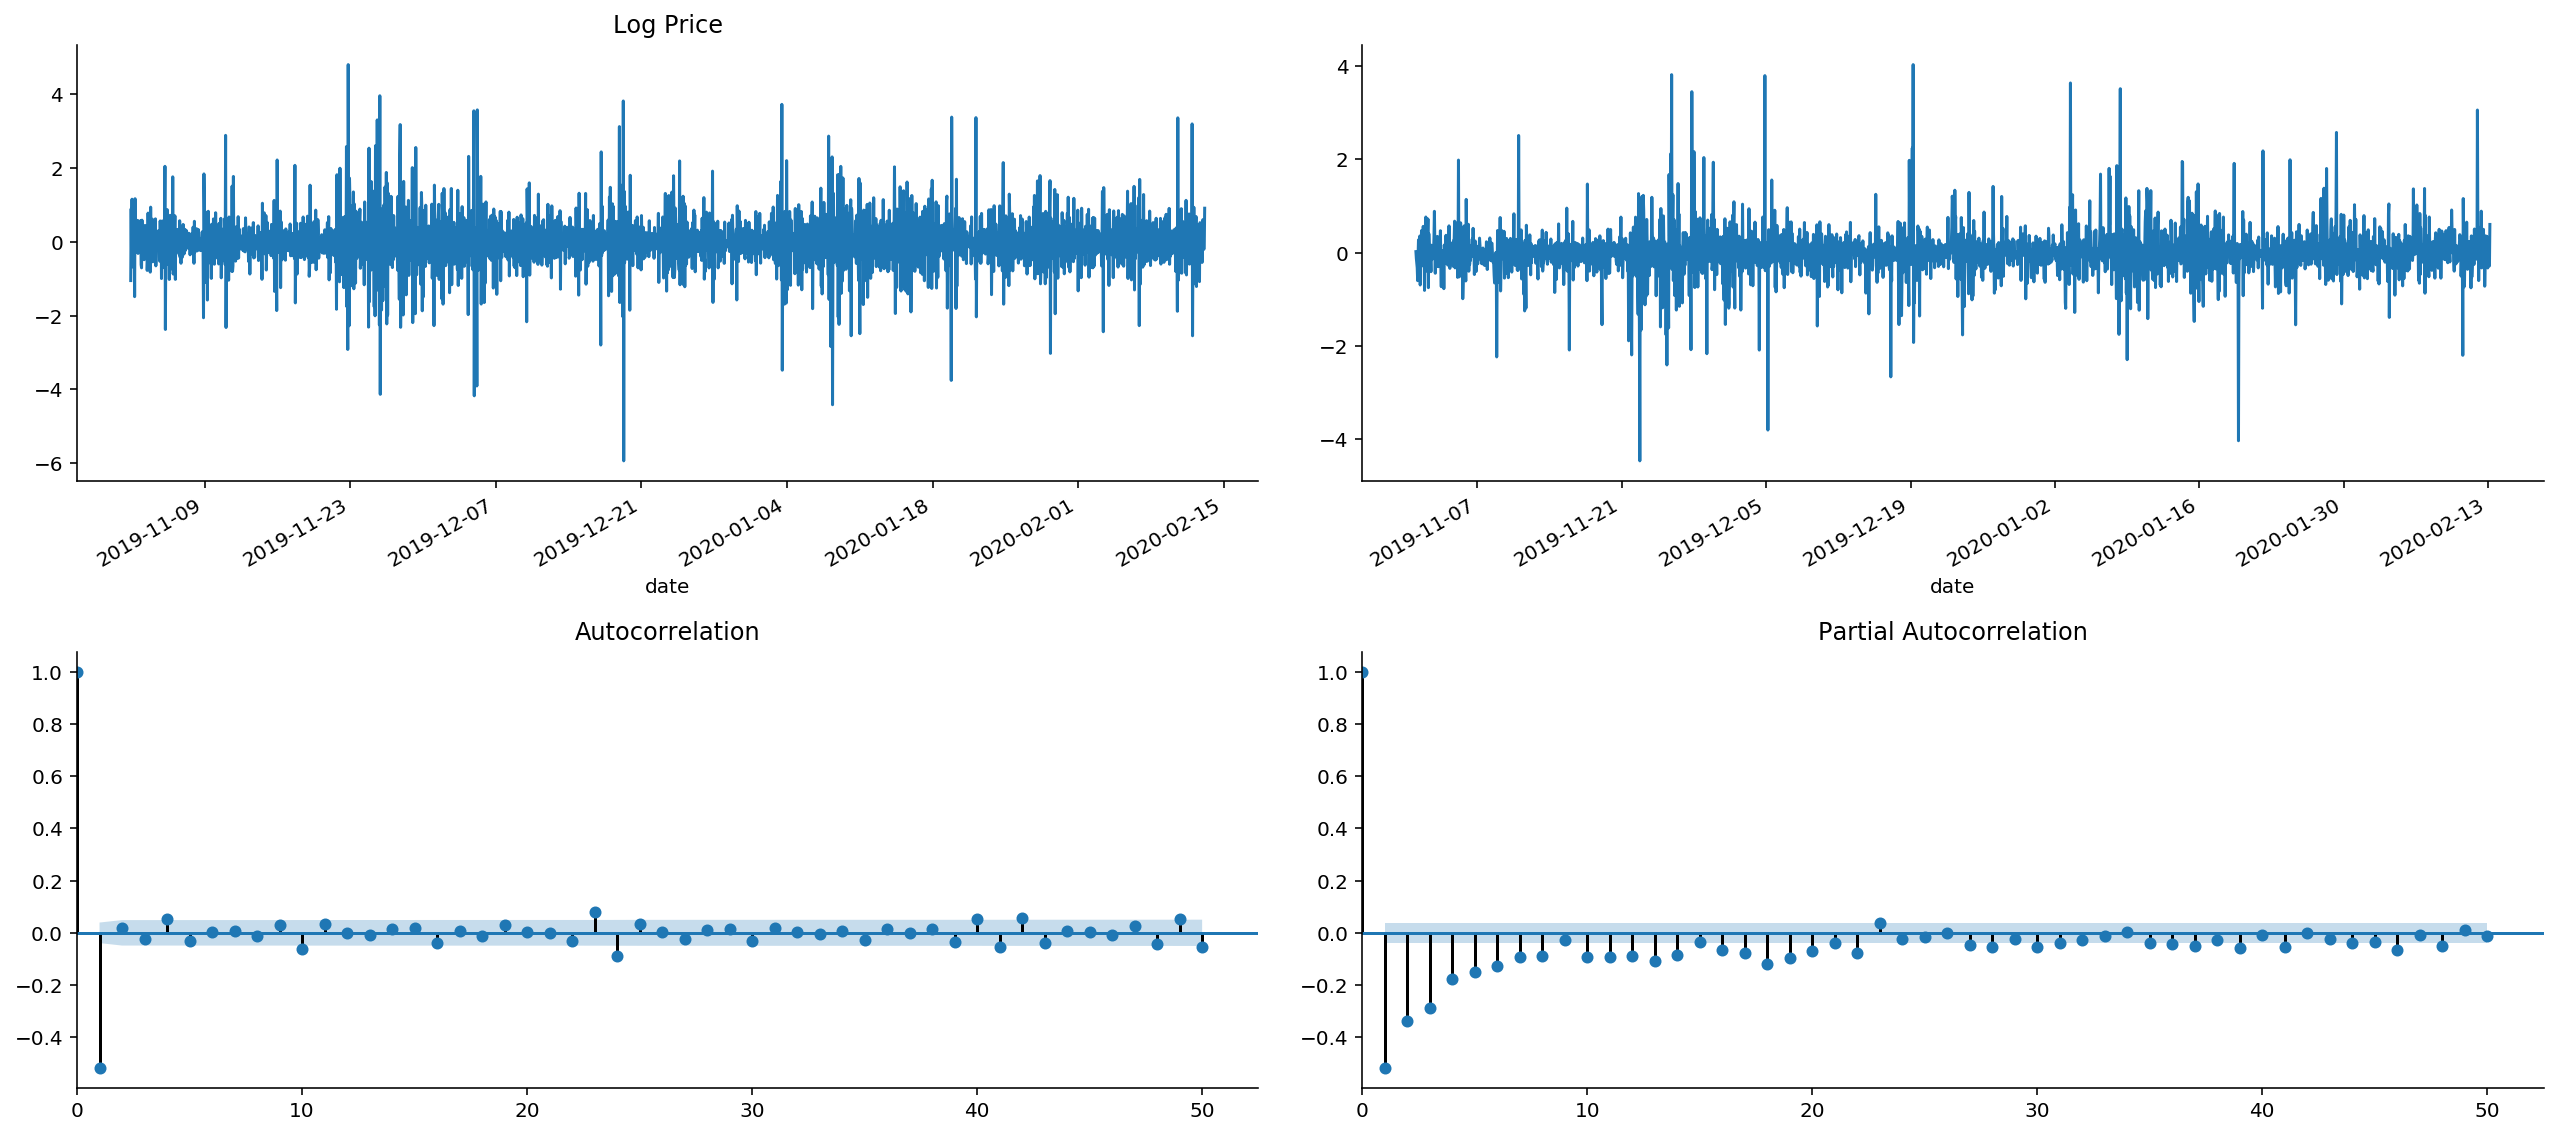

In [183]:
tsplot(model_results.resid[20:],kline_train['log_return_100x'], title='Log Price', lags=50)
# tsplot(kline_train['log_return_100x'], kline_train['realized_volatility_1_hour'], title='Log Return', lags=100)

## 第五步： 模型检验

In [25]:
# 采用不同检验模型检验拟合结果
het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]

sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # 最大周期的最后一个值
sercor_p = sercor_p[-1]

# 对标准化残差进行Durbin-Watson测试。
# 统计量大约等于2*(1-r)，其中r是残差的样本自相关。对于r == 0，表示没有序列相关性，则测试统计量为2。
# 这个统计值总是在0到4之间。统计量越接近0，正序列相关的证据越多。越接近4，负序列相关的证据越多。基本上，低于1或高于3都是不好的。
dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

# 检查根是否在单位圆之外(期望是)，当不使用AR时，为真，或者AR/MA顺序 = 0)
arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

root_test=pd.DataFrame(index=['Durbin-Watson test on residuals','Test for all AR roots outside unit circle (>1)','Test for all MA roots outside unit circle (>1)'],columns=['c'])
root_test['c']['Durbin-Watson test on residuals']=dw
root_test['c']['Test for all AR roots outside unit circle (>1)']=arroots_outside_unit_circle
root_test['c']['Test for all MA roots outside unit circle (>1)']=maroots_outside_unit_circle
root_test

Test heteroskedasticity of residuals (breakvar): stat=0.705, p=0.000

Test normality of residuals (jarquebera): stat=8398.673, p=0.000

Test serial correlation of residuals (ljungbox): stat=152.952, p=0.000

Durbin-Watson test on residuals: d=2.24
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


,c
Durbin-Watson test on residuals,2.24435
Test for all AR roots outside unit circle (>1),True
Test for all MA roots outside unit circle (>1),True


In [26]:
delta = model_results.fittedvalues - training_ts[training_label]
adjR = 1 - delta.var()/training_ts[training_label].var()
# print(adjR**2)
#采用调整后的拟合优度检验：adjR²值在0到1之间，越大说明拟合效果越好。计算该序列的adjR²值，发现效果并不好，这也符合我们的预期。

adjR_test=pd.DataFrame(index=['adjR2'],columns=['Value'])
adjR_test['Value']['adjR2']=adjR**2
adjR_test

,Value
adjR2,5.3653


In [66]:
lags=5
rdtest = lb_test(model_results.resid,lags=lags)
pd.DataFrame({'test statistic':rdtest[0],'p-value':rdtest[1]},index=np.arange(lags)+1)
# p-value>0.05,不能拒绝原假设，认为是白噪声序列，可以继续
# p-value<0.05,拒绝原假设，不是白噪声序列

,test statistic,p-value
1,528.672020,5.493622e-117
2,528.672481,1.585731e-115
3,528.672900,2.914011e-114
4,528.672990,4.206451e-113
5,528.672990,5.154428e-112


## 第六步：模型预测

Alternatively, we can make dynamic forecasts as of some month (January 2013 in the example below). That means the forecast from that point forward only use information available as of January 2013. The predictions are generated in a similar way: a bunch of one-step forecasts. Only instead of plugging in the actual values beyond January 2013, we plug in the forecast values.

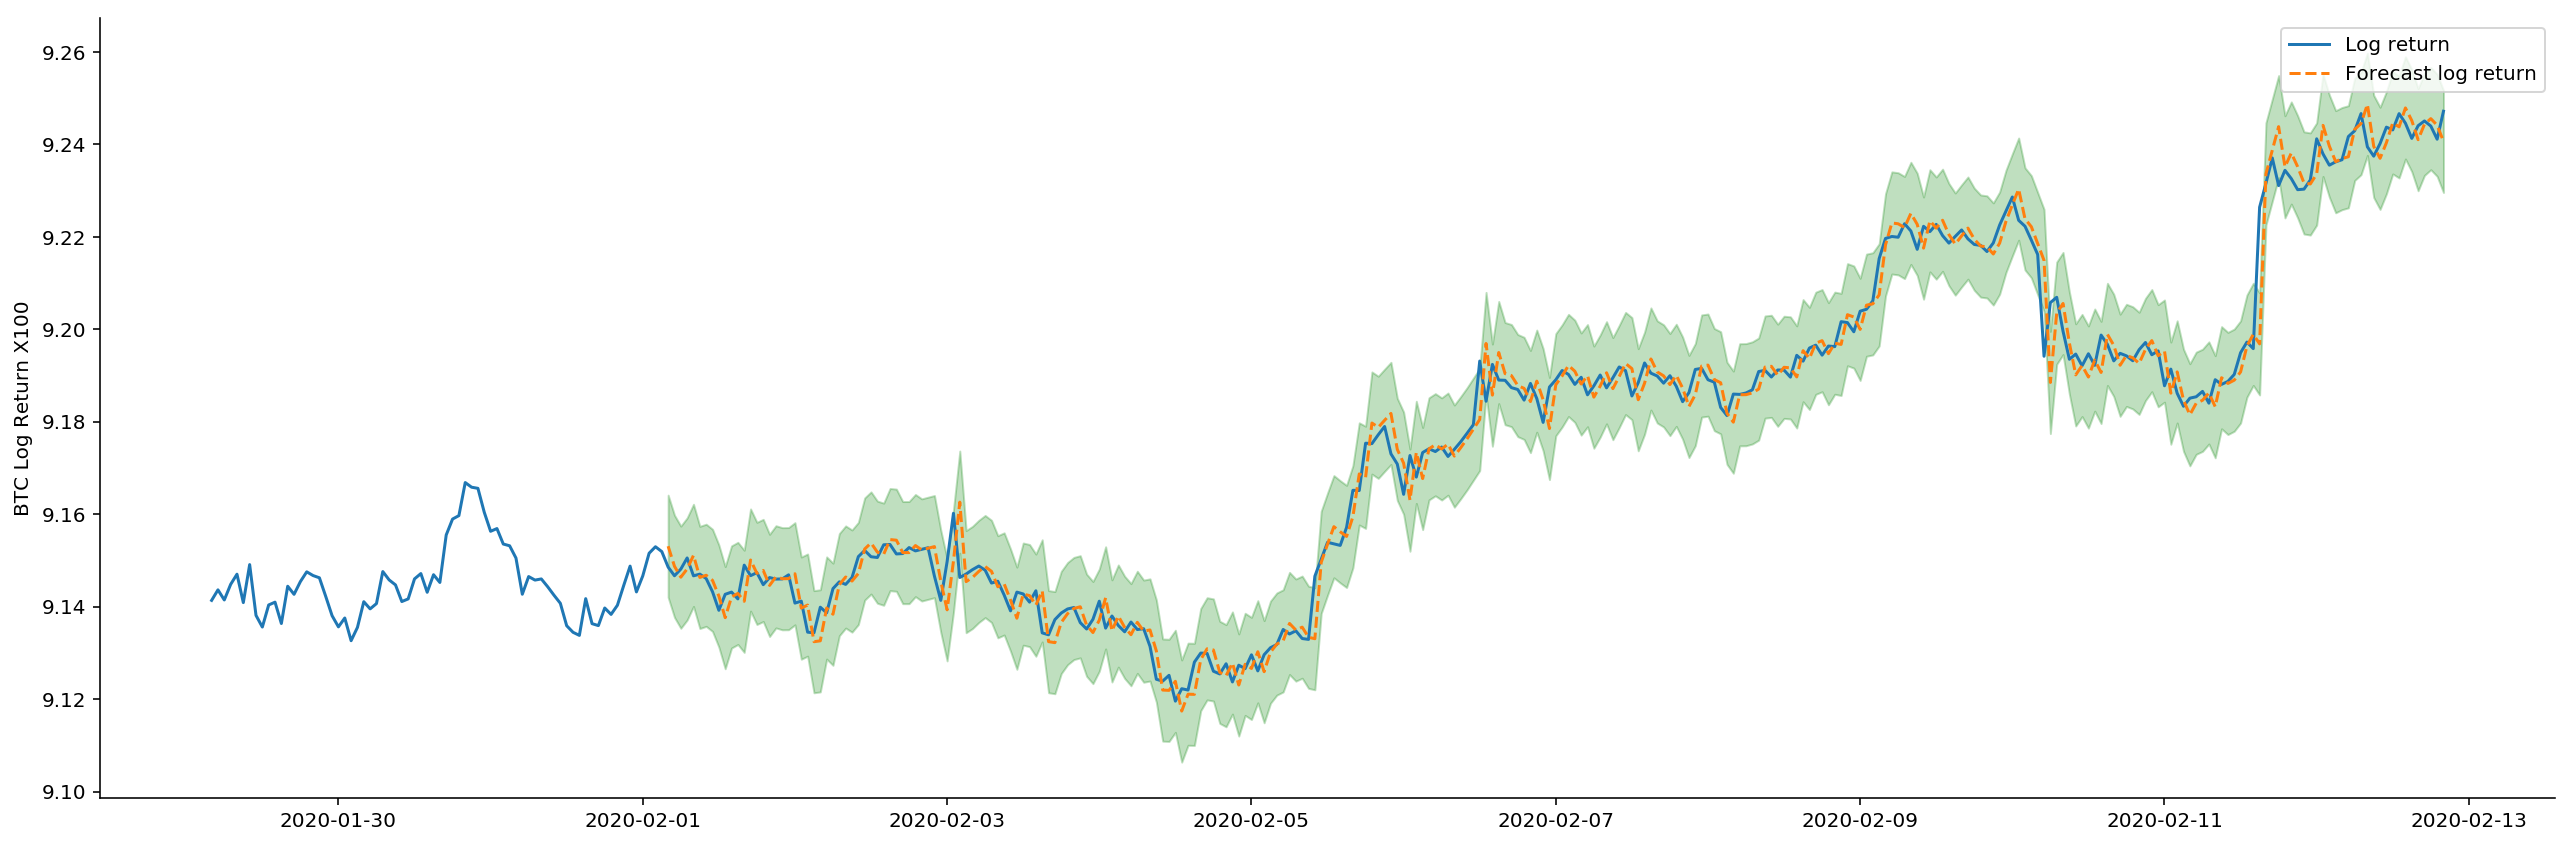

In [27]:
# 预测下N步 SARIMAX
# https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html
begin_date = '2020-01-29 12:00:00+08:00'
start_date = '2020-02-01 12:00:00+08:00'
end_date = '2020-02-01 12:00:00+08:00'

pred_dy = model_results.get_prediction(start=start_date, dynamic=end_date)
pred_dy_ci = pred_dy.conf_int()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax.plot(training_ts[training_label].loc[begin_date:], label='Log return', linestyle='-')
ax.plot(pred_dy.predicted_mean.loc[start_date:], label='Forecast log return', linestyle='--')
ax.fill_between(pred_dy_ci.index,pred_dy_ci.iloc[:, 0],pred_dy_ci.iloc[:, 1], color='g', alpha=.25)

plt.ylabel("BTC Log Return X100")
plt.legend(loc='best')
plt.tight_layout()
sns.despine()

2500


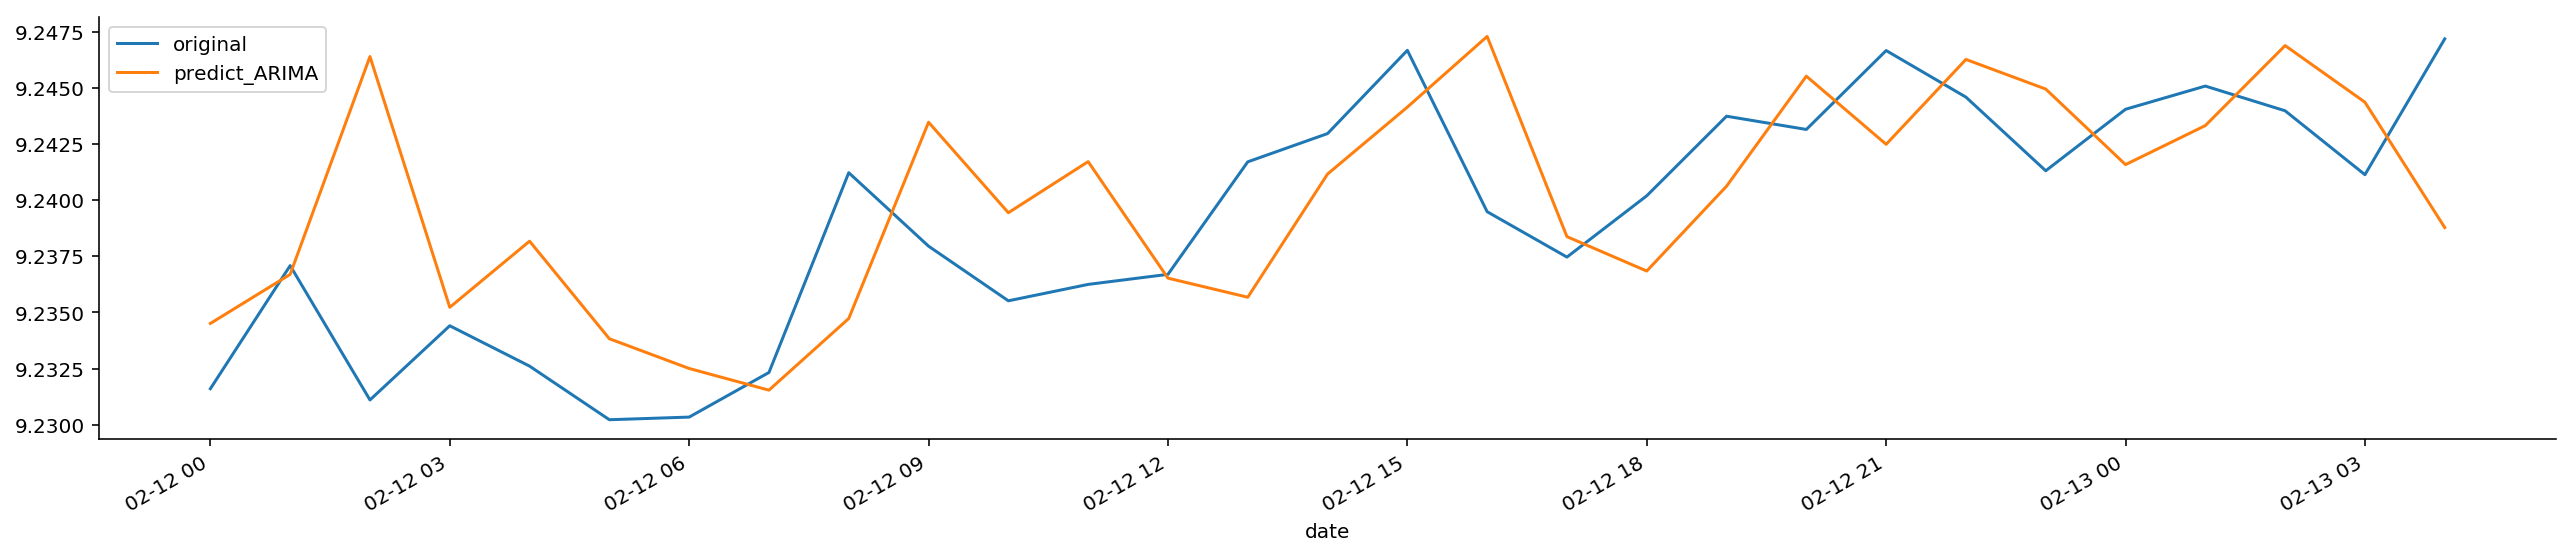

In [61]:
# 样本内的预测数据 predict()
predicts_ARIMA = model_results.predict(dynamic = False)#(233, 243, )
print(len(predicts_ARIMA))
compare_ARMA = pd.DataFrame()
compare_ARMA['original'] = training_ts[training_label]
compare_ARMA['predict_ARIMA'] = predicts_ARIMA
compare_ARMA

fig, ax = plt.subplots(figsize=(18, 4))
start = '2020-02-12 00:00:00+08:00'
end = '2020-03-05 00:00:00+08:00'

compare_ARMA.loc[start:end].plot(ax=ax,label='log compare')
plt.legend(loc='best')
plt.tight_layout()
sns.despine()

### 样本内预测

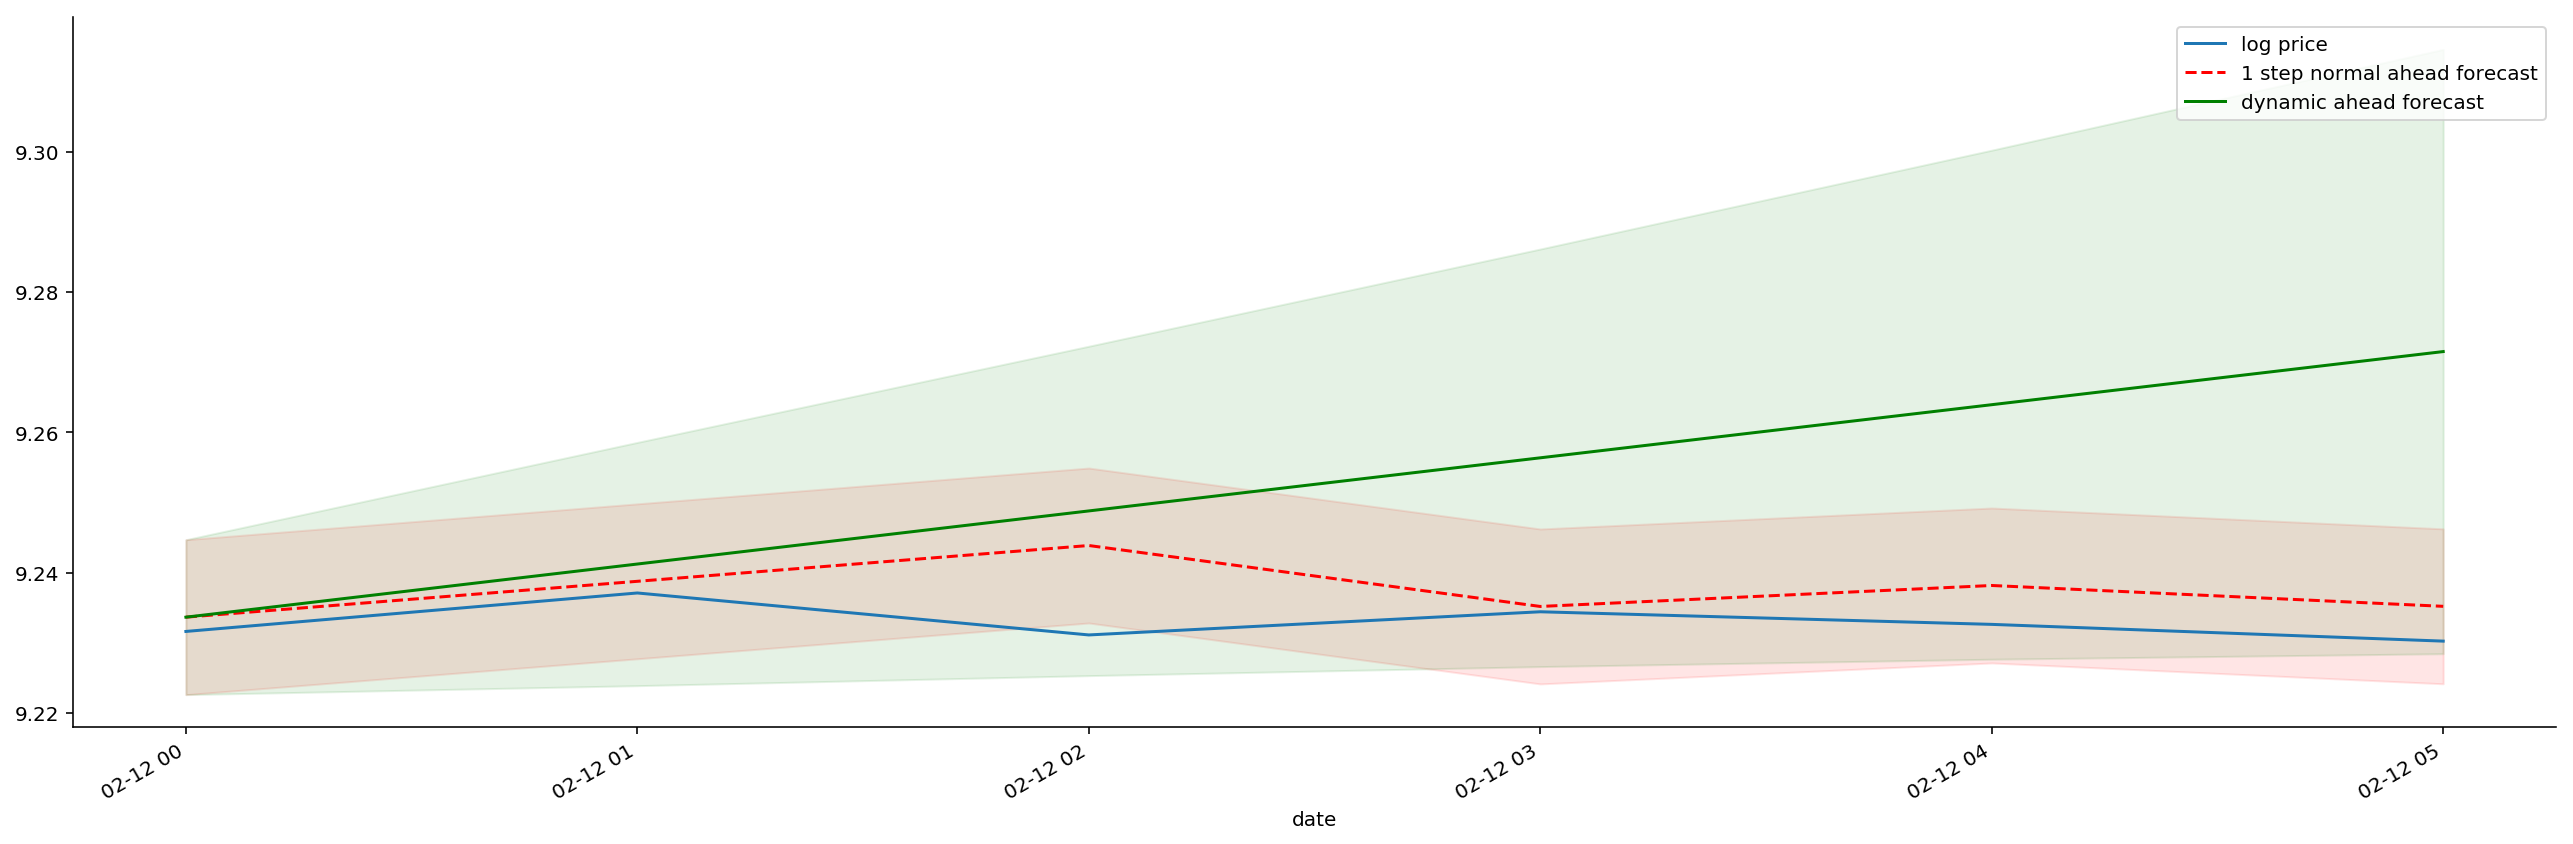

In [33]:
# 样本内的预测数据 predict()
# start_date = '2020-01-12 00:00:00+08:00'
start_date = '2020-02-12 00:00:00+08:00'
end_date = '2020-02-12 05:00:00+08:00'

predicts_ARIMA_normal = model_results.get_prediction(start=start_date, dynamic=False)
predicts_ARIMA_dynamic = model_results.get_prediction(start=start_date, dynamic=True, full_results=False)

# Graph
fig, ax = plt.subplots(figsize=(18,6))
# npre = 4
# ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')
training_ts.loc[start_date:end_date, training_label].plot(ax=ax, label='log price')

predicts_ARIMA_normal.predicted_mean.loc[start_date:end_date].plot(ax=ax, style='r--', label='1 step normal ahead forecast')
ci_normal = predicts_ARIMA_normal.conf_int().loc[start_date:end_date]
ax.fill_between(ci_normal.index, ci_normal.iloc[:,0], ci_normal.iloc[:,1], color='r', alpha=0.1)

predicts_ARIMA_dynamic.predicted_mean.loc[start_date:end_date].plot(ax=ax, style='g', label='dynamic ahead forecast')
ci_dynamic = predicts_ARIMA_dynamic.conf_int().loc[start_date:end_date]
ax.fill_between(ci_dynamic.index, ci_dynamic.iloc[:,0], ci_dynamic.iloc[:,1], color='g', alpha=0.1)

plt.tight_layout()
plt.legend(loc='best')
sns.despine()

### 样本外预测

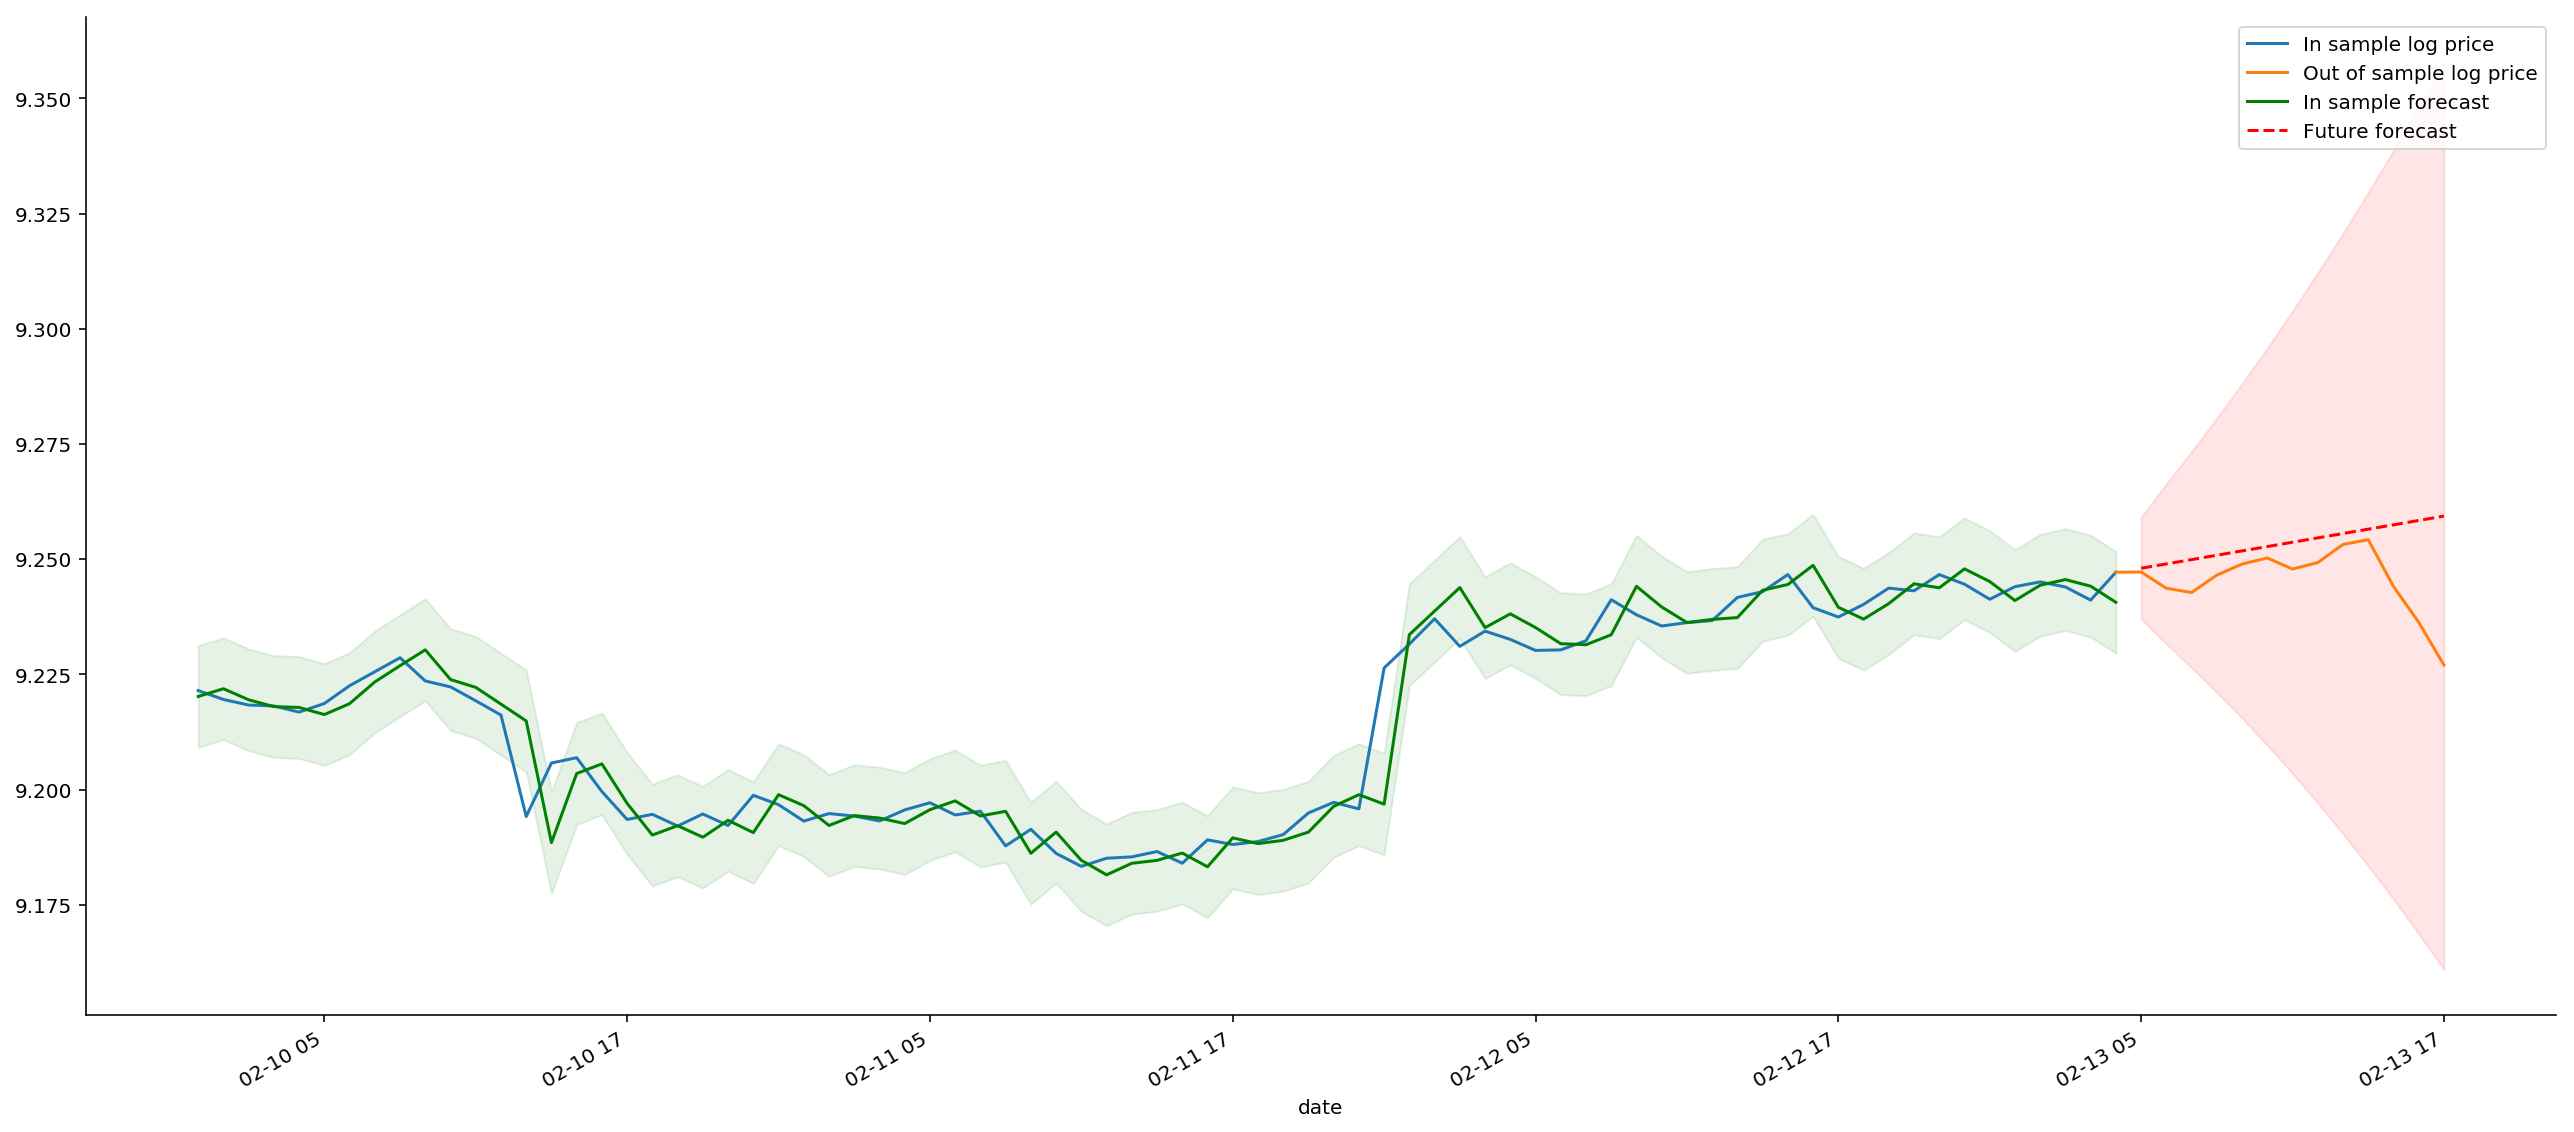

In [34]:
# 样本外的预测数据 predict()
start_date = '2020-02-10 00:00:00+08:00'
# start_date = '2020-02-13 00:00:00+08:00'
end_date = '2020-02-13 17:00:00+08:00'

predict_step = 50
predicts_ARIMA_normal = model_results.get_prediction(start=start_date, dynamic=False)
ci_normal = predicts_ARIMA_normal.conf_int().loc[start_date:]

predicts_ARIMA_normal_out = model_results.get_forecast(steps=predict_step, dynamic=False)
ci_normal_out = predicts_ARIMA_normal_out.conf_int().loc[start_date:end_date]

fig, ax = plt.subplots(figsize=(18,8))
training_ts.loc[start_date:, training_label].plot(ax=ax, label='In sample log price')
testing_ts.loc[:end_date, training_label].plot(ax=ax, label='Out of sample log price')

predicts_ARIMA_normal.predicted_mean.plot(ax=ax, style='g', label='In sample forecast')
ax.fill_between(ci_normal.index, ci_normal.iloc[:,0], ci_normal.iloc[:,1], color='g', alpha=0.1)

predicts_ARIMA_normal_out.predicted_mean.loc[:end_date].plot(ax=ax, style='r--', label='Future forecast')
ax.fill_between(ci_normal_out.index, ci_normal_out.iloc[:,0], ci_normal_out.iloc[:,1], color='r', alpha=0.1)

plt.tight_layout()
plt.legend(loc='best')
sns.despine()

In [37]:
# 评价MSE，0的MSE是估计器将以完美的精度预测参数的观测值，这将是一个理想的场景但通常不可能。
start = '2020-02-12 00:00:00+08:00'
predicts_ARIMA_normal = model_results.get_prediction()
predicts_ARIMA_dynamic = model_results.get_prediction(dynamic=start)

compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['Model'] = ['NORMAL','DYNAMIC']
compare_ARCH_X['RMSE'] = [get_rmse(predicts_ARIMA_normal.predicted_mean, testing_ts[training_label][:10]),
                          get_rmse(predicts_ARIMA_dynamic.predicted_mean, testing_ts[training_label][:10])]
compare_ARCH_X['MAPE'] = [get_mape(predicts_ARIMA_normal.predicted_mean, testing_ts[training_label][:10]),
                          get_mape(predicts_ARIMA_dynamic.predicted_mean, testing_ts[training_label][:10])]
compare_ARCH_X['MASE'] = [get_mase(predicts_ARIMA_normal.predicted_mean, testing_ts[training_label][:10]),
                          get_mase(predicts_ARIMA_dynamic.predicted_mean, testing_ts[training_label][:10])]
compare_ARCH_X

,Model,RMSE,MAPE,MASE
0,NORMAL,0.006533,0.070701,NaN
1,DYNAMIC,0.198809,2.104689,NaN


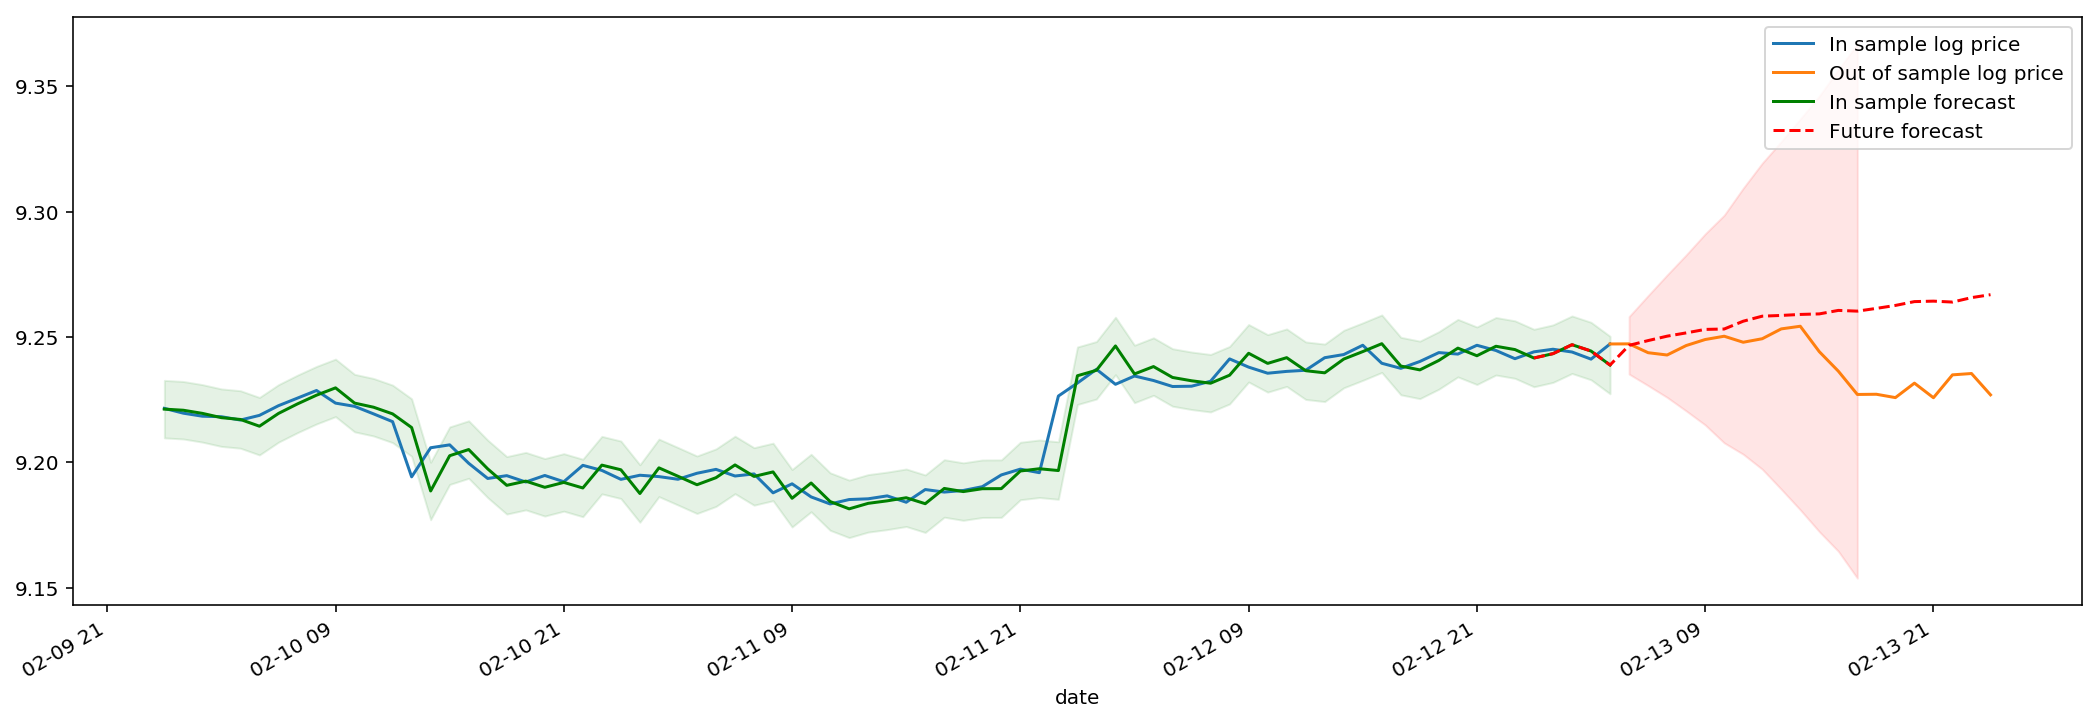

In [123]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotSARIMA(series, model, n_steps):
    start_date = '2020-02-10 00:00:00+08:00'
    start_forecast_date = '2020-02-13 00:00:00+08:00'
    end_date = '2020-02-14 00:00:00+08:00'
    s  = 24
    d=1               #d: 当前序列值计算是否使用First Difference
    data = series.copy()
    data.columns = [training_label]
    data['arima_model'] = model.fittedvalues
    data['arima_model'][:s+d] = np.NaN
    
    predicts_ARIMA_normal = model_results.get_prediction(start=start_date, dynamic=False)
    ci_normal = predicts_ARIMA_normal.conf_int().loc[start_date:]
    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
#     error = mean_absolute_percentage_error(data[training_label][s+d:], data['arima_model'][s+d:])

    fig, ax = plt.subplots(figsize=(18,6))
#     plt.figure(figsize=(18, 7))
#     plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    training_ts.loc[start_date:, training_label].plot(ax=ax, label='In sample log price')
    testing_ts.loc[:end_date, training_label].plot(ax=ax, label='Out of sample log price')

    predicts_ARIMA_normal.predicted_mean.plot(ax=ax, style='g', label='In sample forecast')
    ax.fill_between(ci_normal.index, ci_normal.iloc[:,0], ci_normal.iloc[:,1], color='g', alpha=0.1)

#     predicts_ARIMA_normal_out.predicted_mean.loc[:end_date].plot(ax=ax, style='r--', label='Future forecast')
    ax.fill_between(ci_normal_out.index, ci_normal_out.iloc[:,0], ci_normal_out.iloc[:,1], color='r', alpha=0.1)
    
    forecast.loc[start_forecast_date:].loc[:end_date].plot(ax=ax, style='r--', label='Future forecast')
#     plt.plot(, color='r', label="model")
#     plt.plot(data[training_label].loc[start_date:], label="training_label")
    
#     plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.legend()
    plt.grid(False);
plotSARIMA(training_ts, model_results, 30)

In [35]:
compare_ARIMA = pd.DataFrame()
compare_ARIMA['original_log_price'] = testing_ts['log_price']
compare_ARIMA['predict_log_price'] = predicts_ARIMA_normal_out.predicted_mean
compare_ARIMA['difference'] = compare_ARIMA['original_log_price'] - compare_ARIMA['predict_log_price']
compare_ARIMA = compare_ARIMA[1:]
compare_ARIMA.head(10)
# predicts_ARIMA_normal_out.predicted_mean
# testing_ts

,original_log_price,predict_log_price,difference
date,,,
2020-02-13 05:00:00+08:00,9.247231,9.248052,-0.000821
2020-02-13 06:00:00+08:00,9.243707,9.248992,-0.005285
2020-02-13 07:00:00+08:00,9.242788,9.249932,-0.007144
2020-02-13 08:00:00+08:00,9.246557,9.250873,-0.004316
2020-02-13 09:00:00+08:00,9.248965,9.251814,-0.002849
2020-02-13 10:00:00+08:00,9.250282,9.252756,-0.002474
2020-02-13 11:00:00+08:00,9.247877,9.253698,-0.005822
2020-02-13 12:00:00+08:00,9.249282,9.254642,-0.005360
2020-02-13 13:00:00+08:00,9.253208,9.255586,-0.002378


In [160]:
np.mean(compare_ARIMA['difference'][:10])

-0.005120166886476696

In [36]:
compare_arima_diff = pd.DataFrame(index=['ARIMA'], columns=['head 10 steps', 'head all steps'])
compare_arima_diff['head 10 steps']['ARIMA'] = np.mean(compare_ARIMA['difference'][:10])
compare_arima_diff['head all steps']['ARIMA'] = np.mean(compare_ARIMA['difference'])
compare_arima_diff

,head 10 steps,head all steps
ARIMA,-0.0038717,-0.0344964
